In [1]:
# 该文件用于处理数据并可视化
import csv 
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
#加上这句话，图片会嵌入notebook而不是跳出新窗口查看图片
%matplotlib inline
# 绘制漂亮的图形，避免模糊的图像
%config InlineBackend.figure_format = 'retina'
# 设置环境
sns.set_context('notebook')
sns.set(style="ticks", color_codes=True)
# 忽略警告
import warnings
warnings.filterwarnings('ignore')

# 启用多个单元输出
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

18.380657196044922 6.0 2894.25
18.380657196044922


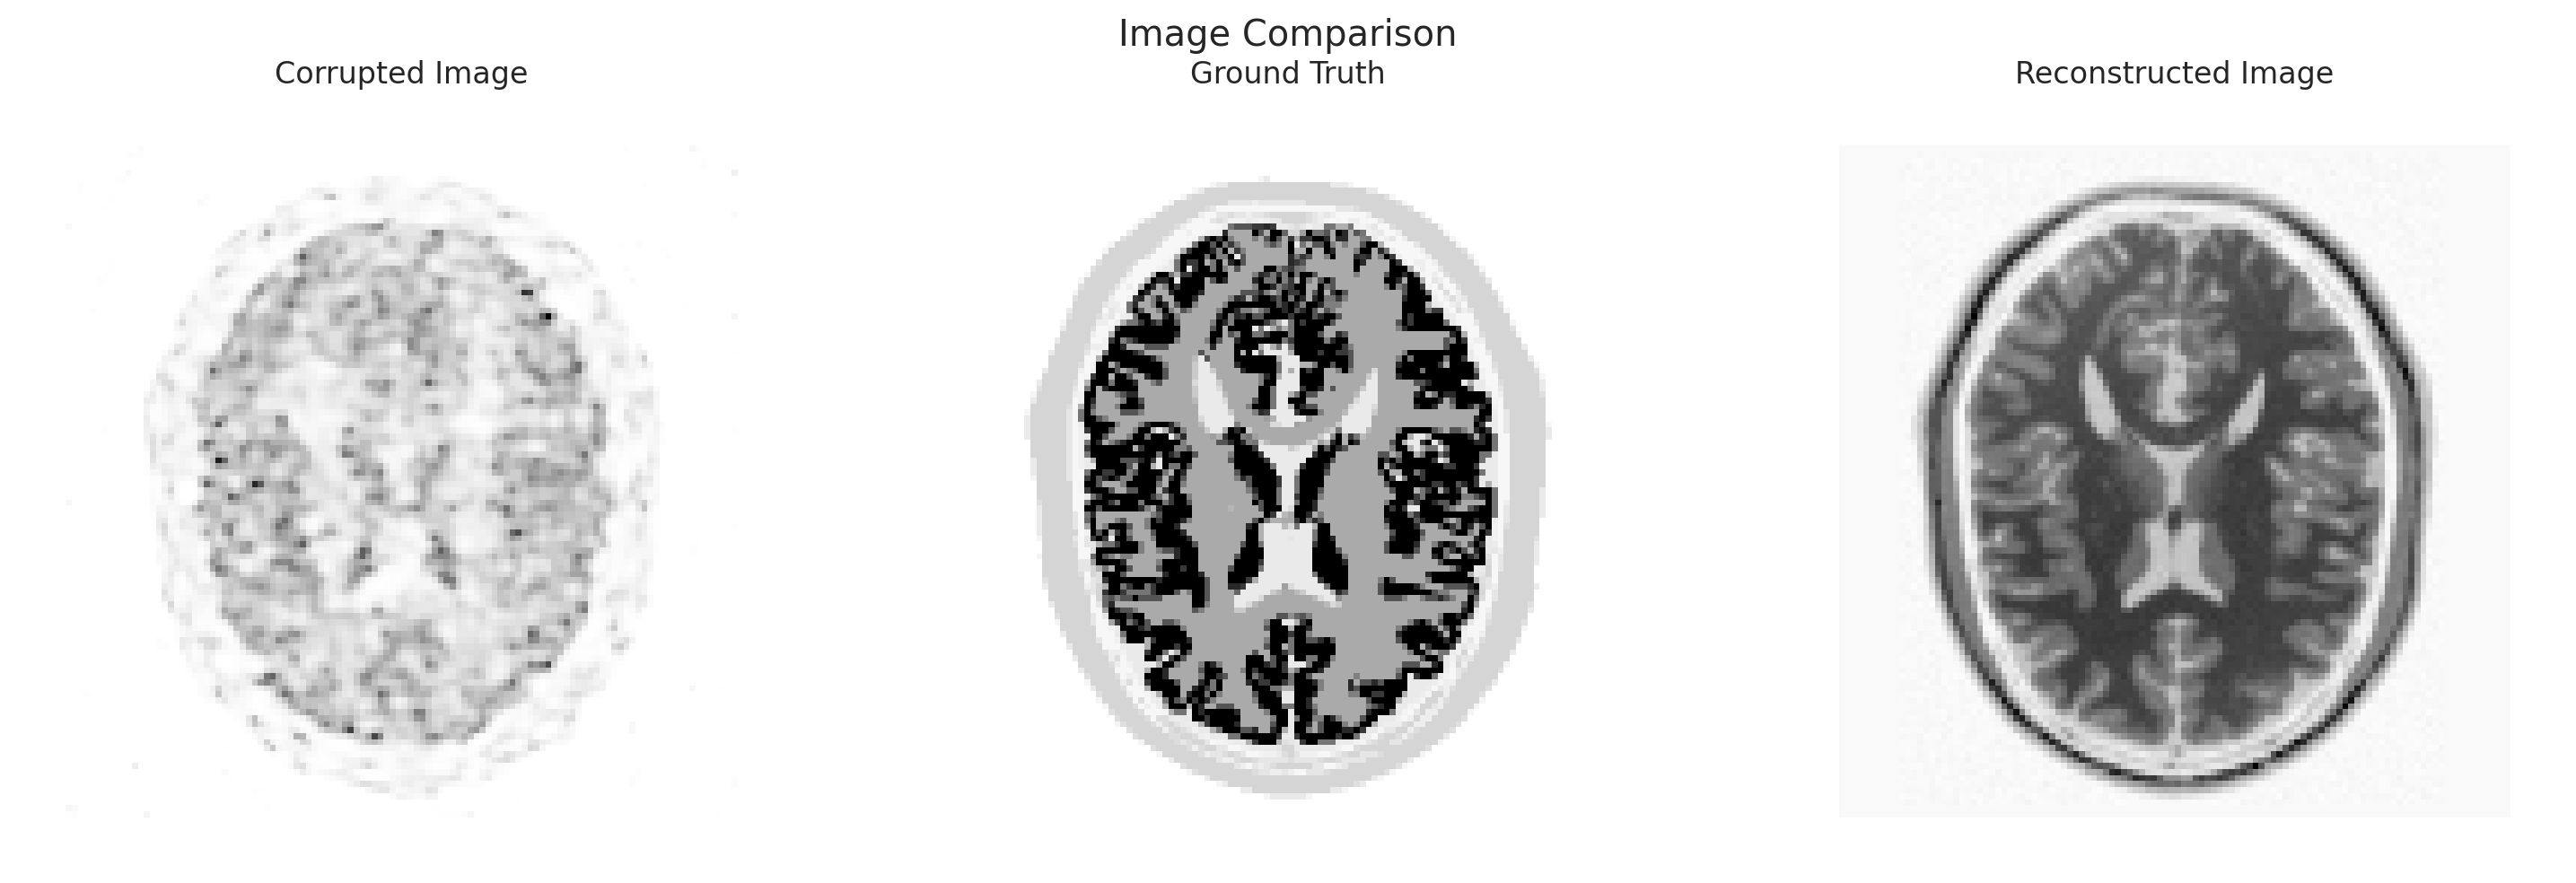

Baseline MSE: 0.9146751660782677
Baseline PSNR: 15.95035612850478
Baseline SSIM: 0.7247992969316387


In [2]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
corrupted_image = np.squeeze(np.load("/home/xzhang/Documents/我的模型/data/corrupted_images/target_padded_brain.npy"))
ground_truth = np.squeeze(np.load("/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_brain.npy"))
# mask = np.squeeze(np.load('/home/xzhang/Documents/我的模型/data/noisy_images/mask_padded.npy'))
# corrupted_image = np.squeeze(np.load("/home/xzhang/Documents/我的模型/data/corrupted_images/target_padded.npy"))
# ground_truth = np.squeeze(np.load("/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_padded.npy"))
mr = np.squeeze(np.load("/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_mr.npy"))
# mse_baseline = np.mean((corrupted_image - ground_truth) ** 2)
mse_baseline = np.mean((corrupted_image - ground_truth) ** 2)
psnr_baseline = peak_signal_noise_ratio(ground_truth, corrupted_image, data_range=np.amax(ground_truth) - np.amin(ground_truth))
ssim_baseline = structural_similarity(ground_truth, corrupted_image, data_range=np.amax(ground_truth) - np.amin(ground_truth))
print(np.max(corrupted_image),np.max(ground_truth),np.max(mr))
mr_scaled = (mr-np.min(mr))*(np.max(corrupted_image)-np.min(corrupted_image))/(np.max(mr)-np.min(mr))
print(np.max(mr_scaled))
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.subplots_adjust(hspace=0.3)


im1 =axes[0].imshow(corrupted_image, cmap='gray_r')
axes[0].set_title('Corrupted Image')
axes[0].axis('off')  # 隐藏坐标轴

# 绘制子图2
im2 =axes[1].imshow(ground_truth, cmap='gray_r')
axes[1].set_title('Ground Truth')
axes[1].axis('off')  # 隐藏坐标轴

# 绘制子图3
im3 =axes[2].imshow(mr_scaled, cmap='gray_r')
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')  # 隐藏坐标轴

# 设置整体图的标题
fig.suptitle('Image Comparison')

# 调整布局
plt.tight_layout()
plt.show()
print("Baseline MSE:", mse_baseline)
print("Baseline PSNR:", psnr_baseline)
print("Baseline SSIM:", ssim_baseline);

# work flow
1. from csv to dataframe :

~~~
df = pd.read_csv().iloc[:,1:] 
~~~


2. for each train, find the min loss,mse,and max psnr,ssim : 
~~~
grouped_df = df_u.groupby(['model', 'num_layers', 'num_channels', 'skip', 'sigma_p','train']).agg({
    'loss': 'min',
    'mse': 'min',
    'psnr': 'max',
    'ssim': 'max'
}).reset_index() 
~~~

3. boxplot
~~~
sns.catplot(x='model'(column name to seperate) , y='mse',row=None,hue = 'skip',col=None, data=data(the dataframe grouped), kind='boxen'(different plot style))
# baseline_value = psnr_baseline #-50  # 假设baseline值为50
# plt.axhline(y = 0.5, color='b', linestyle='--', label='Baseline')
# plt.text(0.2,16, f'Baseline = {psnr_baseline:.2f}', color='b', fontsize=12)  # 添加文字说明 -->
plt.suptitle('MSE with 0,1,2,3')
plt.show();
~~~
4. find the min mse for each train and the iteration related
``` 
grouped_df_v2 = df_u.groupby(['model', 'num_layers', 'num_channels', 'skip', 'sigma_p','train']).apply(lambda x: x.loc[x['mse'].idxmin(),['iteration','mse']]).reset_index()
grouped_df_v2.columns = ['model', 'num_layers', 'num_channels', 'skip', 'sigma_p','train','min_mse_iteration','min_mse']
```
5. find the min and max min_mse (best .worst cases) for all random seeds
```
grouped_df_v3 = grouped_df_v2.groupby(['model', 'num_layers', 'num_channels', 'skip', 'sigma_p']).apply(lambda x: pd.DataFrame({
                'best_mse' : [x.loc[x['min_mse'].idxmin(), 'min_mse']],
                'worst_mse' : [x.loc[x['min_mse'].idxmax(), 'min_mse']],
                'best_result_train': [x.loc[x['min_mse'].idxmin(), 'train']],
                'b_iteration': [x.loc[x['min_mse'].idxmin(), 'min_mse_iteration']],
                'worst_result_train': [x.loc[x['min_mse'].idxmax(), 'train']],
                'w_iteration': [x.loc[x['min_mse'].idxmax(), 'min_mse_iteration']]
            })).reset_index()
```
6. set the path suffix to compute the average,bias,variance images
```
path_suffix = '/home/xzhang/Documents/simplified_pipeline/data/results/images/skip_nb_brain/'
```
7. imshow to plot best,worst,average,bias,variance images
8. plot the mse,psnr,loss,ssim curves during the iterations:
```
filtered_data = filtered_data [(filtered_data ["iteration"] >=10) & (filtered_data ["iteration"] <= 500)]
g = sns.relplot(
    data=filtered_data,
    hue='skip',
    x='iteration',
    y='mse',
    kind='line',
    col=None,
    # style='sigma_p',
    dashes=False,
    ci=None,
    linewidth=1
)
g.set(xlabel="Iteration", ylabel='mse')
plt.show();
```

# step1
settings the way of setting named


In [56]:
# settings = ['num_layers', 'num_channels', 'skip', 'sigma_p']
settings = ['num_layers', 'embed_dims', 'skip', 'depths']

In [57]:

df_n = pd.read_csv('/home/xzhang/Documents/simplified_pipeline/data/results/images/dip_bagging/test_swin_unetr_v2.csv').iloc[:,1:]
# df_n.loc[df_n[df_n['model']=='non_res_act_concat_2_7'].index,'skip_type'] = 'concat'
# df_n.loc[df_n[df_n['model']=='res_act_concat_2_7'].index,'skip_type'] = 'concat'
# df_n.loc[df_n[df_n['model']=='non_res_act_2_7'].index,'skip_type'] = 'add'
# df_n.loc[df_n[df_n['model']=='res_act_2_7'].index,'skip_type'] = 'add'
# df_n.loc[df_n[df_n['model']=='non_res_act_concat_2_7'].index,'res'] = 'non_res'
# df_n.loc[df_n[df_n['model']=='res_act_concat_2_7'].index,'res'] = 'res'
# df_n.loc[df_n[df_n['model']=='non_res_act_2_7'].index,'res'] = 'non_res'
# df_n.loc[df_n[df_n['model']=='res_act_2_7'].index,'res'] = 'res'
# df_n = df_n.drop(df_n[df_n['model'] =='bilinear'].index)
# df_n.to_csv('/home/xzhang/Documents/simplified_pipeline/metrics/skip_connection/skip_study.csv')
df_n

,model,num_layers,embed_dims,depths,skip,train,iteration,loss,mse,psnr,ssim
0,bagging_res_dip,3,16,2,3,train_0,0,5.280977,5.187530,8.413419,0.000611
1,bagging_res_dip,3,16,2,3,train_0,1,44.641535,44.586653,-0.929024,-0.000424
2,bagging_res_dip,3,16,2,3,train_0,2,317.135671,317.294611,-9.451602,0.002589
3,bagging_res_dip,3,16,2,3,train_0,3,12.006120,12.062904,4.748506,0.038167
4,bagging_res_dip,3,16,2,3,train_0,4,22.451261,22.327142,2.074694,-0.024431
...,...,...,...,...,...,...,...,...,...,...,...
79995,bagging_dip,3,16,2,3,train_49,795,0.035397,0.913342,15.956693,0.669286
79996,bagging_dip,3,16,2,3,train_49,796,0.038422,0.859497,16.220584,0.557886
79997,bagging_dip,3,16,2,3,train_49,797,0.040033,0.902165,16.010166,0.549706
79998,bagging_dip,3,16,2,3,train_49,798,0.043533,0.875882,16.138571,0.487045


In [60]:
df_u = pd.read_csv('/home/xzhang/Documents/simplified_pipeline/metrics/skip_connection/skip_nb_brain.csv').iloc[:,1:]
# df_u.to_csv('/home/xzhang/Documents/simplified_pipeline/metrics/skip_connection/skip_study_v2.csv')
# df_u['dis'] = 'uniform'
df_u.head()

,model,num_layers,num_channels,skip,sigma_p,train,iteration,loss,mse,psnr,ssim
0,DIP_skip_add_mr,3,128,3,0,train_0,0,201.261005,201.021441,-7.469399,0.225206
1,DIP_skip_add_mr,3,128,3,0,train_0,1,92.266836,92.246722,-4.086484,0.098524
2,DIP_skip_add_mr,3,128,3,0,train_0,2,39.482183,39.325037,-0.383666,0.058133
3,DIP_skip_add_mr,3,128,3,0,train_0,3,12.351787,12.226711,4.689929,0.044308
4,DIP_skip_add_mr,3,128,3,0,train_0,4,6.462757,6.365545,7.524669,0.052841


In [69]:
# possible to combine two csv files into one
df = pd.concat([df_n,df_u],axis=0)
# df.to_csv('/home/xzhang/Documents/simplified_pipeline/metrics/skip_connection/skip_study_v2.csv')
df.head()
df['model'].unique()

,model,num_layers,embed_dims,depths,skip,train,iteration,loss,mse,psnr,ssim,num_channels,sigma_p
0,bagging_res_dip,3,16.0,2.0,3,train_0,0,5.280977,5.187530,8.413419,0.000611,NaN,NaN
1,bagging_res_dip,3,16.0,2.0,3,train_0,1,44.641535,44.586653,-0.929024,-0.000424,NaN,NaN
2,bagging_res_dip,3,16.0,2.0,3,train_0,2,317.135671,317.294611,-9.451602,0.002589,NaN,NaN
3,bagging_res_dip,3,16.0,2.0,3,train_0,3,12.006120,12.062904,4.748506,0.038167,NaN,NaN
4,bagging_res_dip,3,16.0,2.0,3,train_0,4,22.451261,22.327142,2.074694,-0.024431,NaN,NaN


array(['bagging_res_dip', 'bagging_dip', 'DIP_skip_add_mr'], dtype=object)

In [265]:
df = df.drop(df[df['model'] =='bagging_50'].index)
df = df.drop(df[df['model'] =='bilinear_non_act'].index)
df = df.drop(df[df['model'] =='bilinear_res'].index)
df = df.drop(df[df['model'] =='bilinear_res_act'].index)
df = df.drop(df[df['model'] =='bilinear'].index)


# step2

In [86]:
grouped_df = df.groupby(['model', *settings,'train']).agg({
    'loss': 'min',
    'mse': 'min',
    'psnr': 'max',
    'ssim': 'max'
    
}).reset_index()
grouped_df.tail()
grouped_df['model'].unique()

,model,num_layers,embed_dims,skip,depths,train,loss,mse,psnr,ssim
295,bagging_res_dip,3,16.0,3,2.0,train_5,0.026604,0.431933,19.208860,0.795223
296,bagging_res_dip,3,16.0,3,2.0,train_6,0.051536,0.441835,19.110424,0.797514
297,bagging_res_dip,3,16.0,3,2.0,train_7,0.046194,0.438305,19.145262,0.779998
298,bagging_res_dip,3,16.0,3,2.0,train_8,0.030855,0.443415,19.094926,0.788141
299,bagging_res_dip,3,16.0,3,2.0,train_9,0.017874,0.438103,19.147264,0.794603


array(['DIP_skip_add_mr', 'bagging_dip', 'bagging_res_dip'], dtype=object)

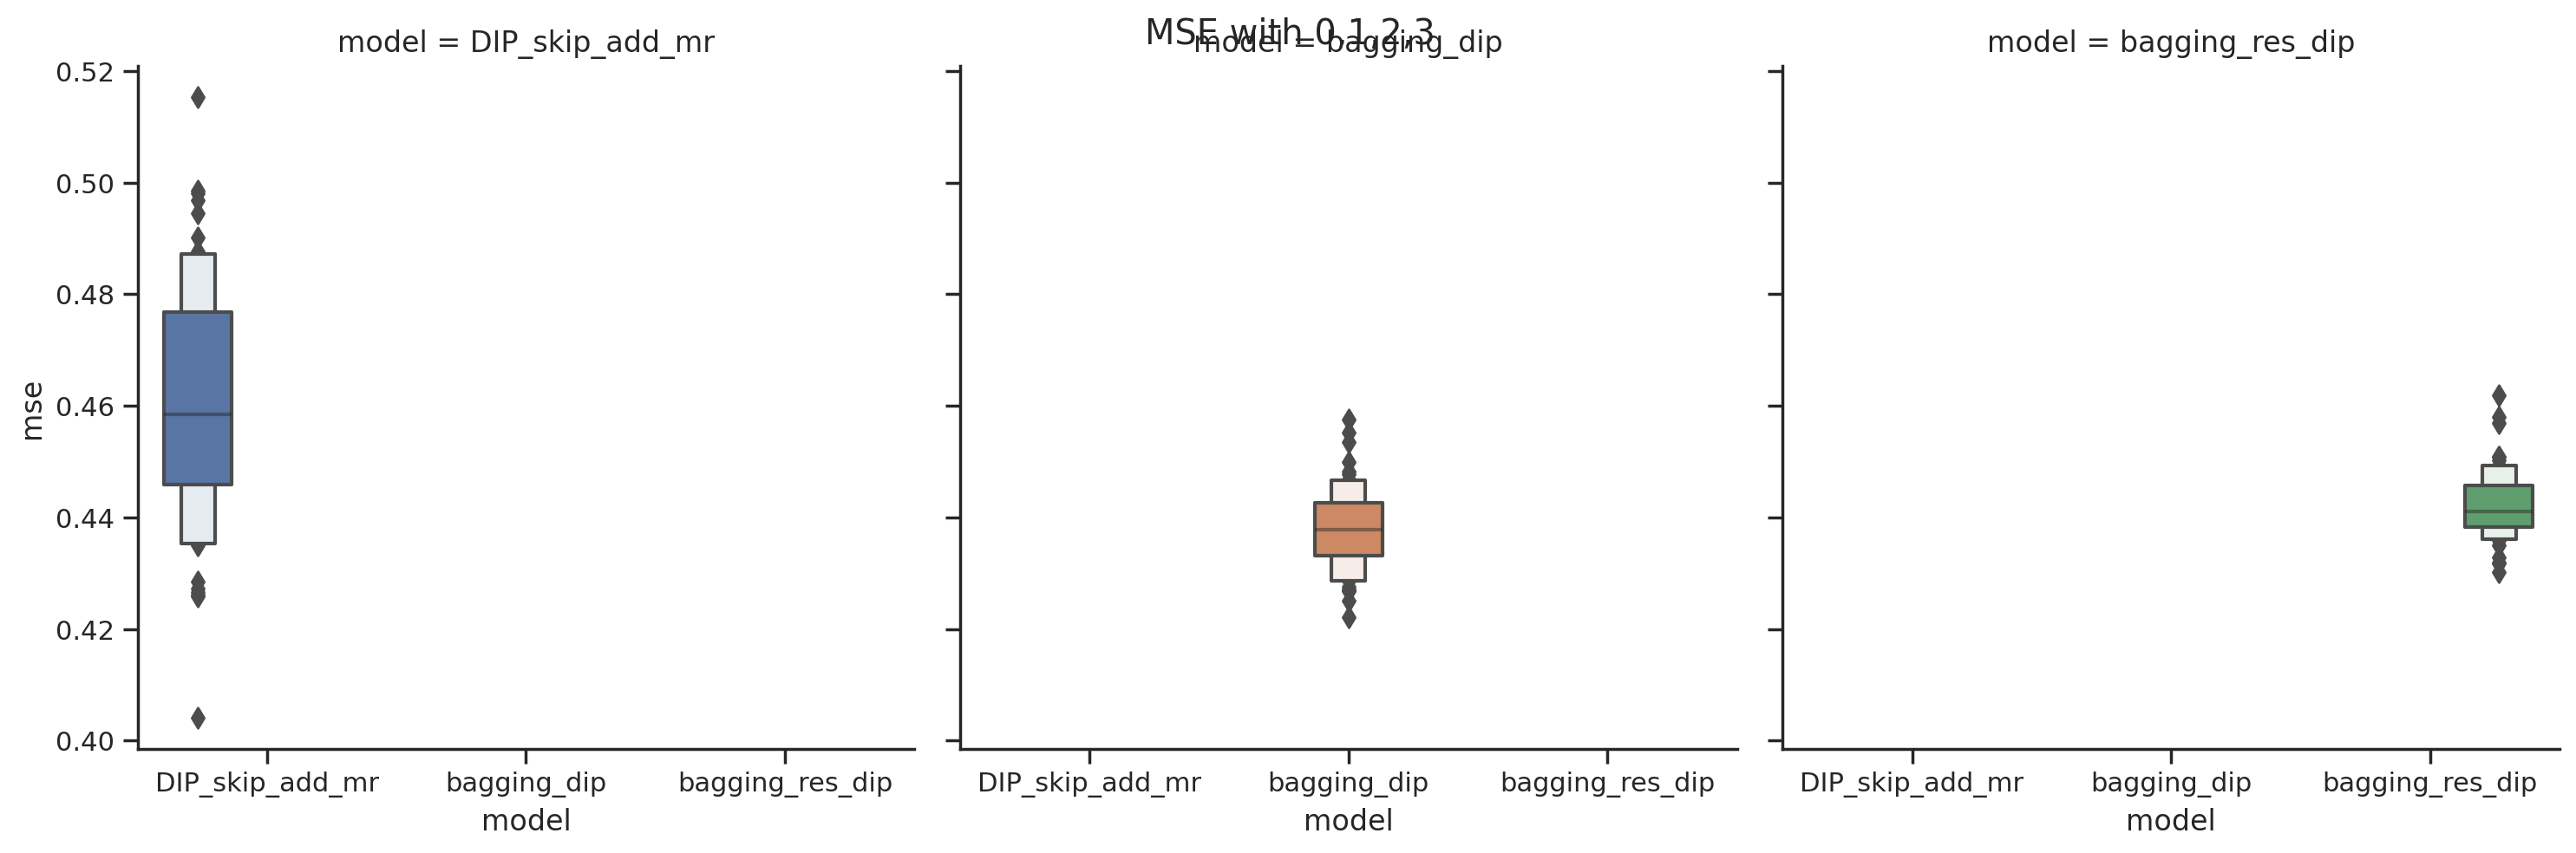

In [88]:
data = grouped_df
# data = data.drop(data[data['model']=='bilinear_res'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='res_act_2_7'].index).reset_index(drop=True)
# # data = data.drop(data[data['model']=='bilinear'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='res_act_concat_2_7'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='non_res_concat_2_7_0.1'].index).reset_index(drop=True)
# data["model"] = data["model"].replace("non_res_act_2_7", "n_res")
# data["model"] = data["model"].replace("res_act_2_7", "res")
# data["model"] = data["model"].replace("non_res_act_concat_2_7", "n_res_c")
# data["model"] = data["model"].replace("res_act_concat_2_7", "res_c")
# data["model"] = data["model"].replace("Full_DIP_backbone_normal", "DIP_without_skip")
# data["model"] = data["model"].replace("Full_DIP_backbone_uniform","DIP_without_skip")

# data["model"] = data["model"].replace("Full_DIP_backbone_kaiming_norm_brain", "kaiming")
# data["model"] = data["model"].replace("Full_DIP_backbone_kaiming_uniform_brain", "kaiming")
# data["model"] = data["model"].replace("Full_DIP_backbone_xavier_norm_brain", "xavier")
# data["model"] = data["model"].replace("Full_DIP_backbone_xavier_uniform_brain", "xavier")

# data = data.drop(data[data['model']=='mr'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v3'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v0'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v1'].index).reset_index(drop=True)
data = data.drop(data[ (data['mse']>1)].index)
data = data.drop(data[ (data['skip']<3)].index)
# data = data.drop(data[ (data['sigma_p']==0.5) ].index)
# data = data.drop(data[ (data['sigma_p']==0.1) ].index)
# # data = data.drop(data[ (data['sigma_p']>0.5) & (data['model']=='Full_DIP_noise_v0')].index)
# data = data.drop(data[ (data['sigma_p']>4) & (data['model'] == 'v0')].index)
# data = data.drop(data[ (data['sigma_p']>0.5) & (data['model'] == 'v3')].index)
sns.catplot(x='model', y='mse',row=None,hue =None,col='model', data=data, kind='boxen')
baseline_value = psnr_baseline #-50  # 假设baseline值为50
# plt.axhline(y = 0.5, color='b', linestyle='--', label='Baseline')
# plt.text(0.2,16, f'Baseline = {psnr_baseline:.2f}', color='b', fontsize=12)  # 添加文字说明
plt.suptitle('MSE with 0,1,2,3')
plt.show();

In [73]:
# df =df_n
# df["model"] = df["model"].replace("Full_DIP_backbone_normal", "DIP")
# df["model"] = df["model"].replace("Full_DIP_backbone_uniform","DIP")
# df["model"] = df["model"].replace("DIP","DIP_without_skip")
# df = df.drop(df[ (df['mse']>1) ].index)
grouped_df_v2 = df_n.groupby(['model', 'num_layers', 'embed_dims', 'skip', 'depths','train']).apply(lambda x: x.loc[x['mse'].idxmin(),['iteration','mse']]).reset_index()
grouped_df_v2.columns = ['model','num_layers', 'embed_dims', 'skip', 'depths','train','min_mse_iteration','min_mse']
# grouped_df_v2 = df_u.groupby(['model', 'num_layers', 'num_channels', 'skip', 'sigma_p','train']).apply(lambda x: x.loc[x['mse'].idxmin(),['iteration','mse']]).reset_index()
# grouped_df_v2.columns = ['model', 'num_layers', 'num_channels', 'skip', 'sigma_p','train','min_mse_iteration','min_mse']
# grouped_df_v2['sigma_p'] = grouped_df_v2['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
grouped_df_v2

,model,num_layers,embed_dims,skip,depths,train,min_mse_iteration,min_mse
0,bagging_dip,3,16,3,2,train_0,138,0.427608
1,bagging_dip,3,16,3,2,train_1,150,0.455229
2,bagging_dip,3,16,3,2,train_10,139,0.433050
3,bagging_dip,3,16,3,2,train_11,171,0.442952
4,bagging_dip,3,16,3,2,train_12,143,0.432760
...,...,...,...,...,...,...,...,...
95,bagging_res_dip,3,16,3,2,train_5,202,0.431933
96,bagging_res_dip,3,16,3,2,train_6,207,0.441835
97,bagging_res_dip,3,16,3,2,train_7,167,0.438305
98,bagging_res_dip,3,16,3,2,train_8,160,0.443415


In [74]:
grouped_df_v3 = grouped_df_v2.groupby(['model', 'num_layers', 'embed_dims', 'skip', 'depths']).apply(lambda x: pd.DataFrame({
                'best_mse' : [x.loc[x['min_mse'].idxmin(), 'min_mse']],
                'worst_mse' : [x.loc[x['min_mse'].idxmax(), 'min_mse']],
                'best_result_train': [x.loc[x['min_mse'].idxmin(), 'train']],
                'b_iteration': [x.loc[x['min_mse'].idxmin(), 'min_mse_iteration']],
                'worst_result_train': [x.loc[x['min_mse'].idxmax(), 'train']],
                'w_iteration': [x.loc[x['min_mse'].idxmax(), 'min_mse_iteration']]
            })).reset_index()
# grouped_df_v3 = grouped_df_v2.groupby(['model', 'num_layers', 'num_channels', 'skip', 'sigma_p']).apply(lambda x: pd.DataFrame({
#                 'best_mse' : [x.loc[x['min_mse'].idxmin(), 'min_mse']],
#                 'worst_mse' : [x.loc[x['min_mse'].idxmax(), 'min_mse']],
#                 'best_result_train': [x.loc[x['min_mse'].idxmin(), 'train']],
#                 'b_iteration': [x.loc[x['min_mse'].idxmin(), 'min_mse_iteration']],
#                 'worst_result_train': [x.loc[x['min_mse'].idxmax(), 'train']],
#                 'w_iteration': [x.loc[x['min_mse'].idxmax(), 'min_mse_iteration']]
#             })).reset_index()
# grouped_df_v3['sigma_p'] = grouped_df_v3['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
data = grouped_df_v3
data

,model,num_layers,embed_dims,skip,depths,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,bagging_dip,3,16,3,2,0,0.422042,0.457539,train_33,161,train_21,167
1,bagging_res_dip,3,16,3,2,0,0.430130,0.461866,train_33,179,train_1,187


In [91]:

# average image
path_suffix = '/home/xzhang/Documents/simplified_pipeline/data/results/images/dip_bagging/'
ground_truth = np.load("/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_brain.npy")
grouped_df = grouped_df_v2.groupby(['model', *settings])
def get_file_list(group):
    files = []
    for train, iteration in zip(group['train'], group['min_mse_iteration']):
        files.append(f'{train}/iters_{iteration}.npy')
    return files

# 应用函数并创建新的DataFrame
result_df = grouped_df.apply(get_file_list).reset_index(name='files')
result_df.head()
# path_suffix = '/home/xzhang/Documents/simplified_pipeline/data/results/images/normal_input/'
# path_suffix = '/hdd/23_07/noise_test/'
for i,row in result_df.iterrows():
    average = np.zeros((128,128))
    for file in row['files']:
    #     file_name = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/{file}"
    #     average += np.load(file_name)
    # average /= len(row['files'])
    # print(average.shape)
    # bias = average - ground_truth[:,:,0] 
    # print(bias.shape)
    # np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/average.npy",arr=average)
    # np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/bias.npy",arr=bias)
    # print(f"adding bias image for {row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}")
    # print(f"adding average image for {row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}")
    # variance = np.zeros((128,128))
    # for file in row['files']:
    #     file_name = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/{file}"
    #     variance += (np.load(file_name)-average)**2
    # variance /= (len(row['files'])-1)
    # np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/variance.npy",arr=variance)
    # print(f"adding variance image for {row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}")

        file_name = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/{file}"
        average += np.load(file_name)
    average /= len(row['files'])
    print(average.shape)
    bias = average - ground_truth[:,:,0] 
    print(bias.shape)
    np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/average.npy",arr=average)
    np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/bias.npy",arr=bias)
    print(f"adding bias image for {row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}")
    print(f"adding average image for {row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}")
    variance = np.zeros((128,128))
    for file in row['files']:
        file_name = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/{file}"
        variance += (np.load(file_name)-average)**2
    variance /= (len(row['files'])-1)
    np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/variance.npy",arr=variance)
    print(f"adding variance image for {row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}")


,model,num_layers,embed_dims,skip,depths,files
0,bagging_dip,3,16,3,2,"[train_0/iters_138.npy, train_1/iters_150.npy,..."
1,bagging_res_dip,3,16,3,2,"[train_0/iters_144.npy, train_1/iters_187.npy,..."


(128, 128)
(128, 128)
adding bias image for bagging_dip/3_16_2_3
adding average image for bagging_dip/3_16_2_3
adding variance image for bagging_dip/3_16_2_3
(128, 128)
(128, 128)
adding bias image for bagging_res_dip/3_16_2_3
adding average image for bagging_res_dip/3_16_2_3
adding variance image for bagging_res_dip/3_16_2_3


In [76]:
data = grouped_df_v3
# data["model"] = data["model"].replace("Full_DIP_noise_v0", "v0")
# data["model"] = data["model"].replace("Full_DIP_noise_v1", "v1")
# data["model"] = data["model"].replace("Full_DIP_noise_v2", "v2")
# data["model"] = data["model"].replace("Full_DIP_noise_v3", "v3")
# data = data[data['model']=='Full_DIP'].reset_index(drop=True)
# data = data.drop(data[data['model']=='bilinear'].index).reset_index(drop=True)
# # data = data.drop(data[data['model']=='conv_3'].index).reset_index(drop=True)
# # data = data.drop(data[data['skip']!=4].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='bilinear_res'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='bilinear_non_act'].index).reset_index(drop=True)
# # data = data.drop(data[data['model']=='Full_DIP_noise_v3'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v2'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v3'].index).reset_index(drop=True)
# data = data.drop(data[ (data['sigma_p']==0.5) ].index)
# data = data.drop(data[ (data['sigma_p']=='0.1') ].index)
# # data = data.drop(data[ (data['sigma_p']=='5') ].index)
# # data = data.drop(data[ (data['sigma_p']>0.5) & (data['model']=='Full_DIP_noise_v0')].index)
# data = data.drop(data[ (data['sigma_p']!='1') & (data['model'] == 'Full_DIP_noise_v0')].index)
# # data = data.drop(data[ (data['sigma_p']>4) & (data['model'] == 'v3')].index)
# data = data.drop(data[data['sigma_p']=='10'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v1'].index).reset_index(drop=True)
# # data = data.drop(data[data['model']=='v2'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v3'].index).reset_index(drop=True)
data

,model,num_layers,embed_dims,skip,depths,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,bagging_dip,3,16,3,2,0,0.422042,0.457539,train_33,161,train_21,167
1,bagging_res_dip,3,16,3,2,0,0.430130,0.461866,train_33,179,train_1,187


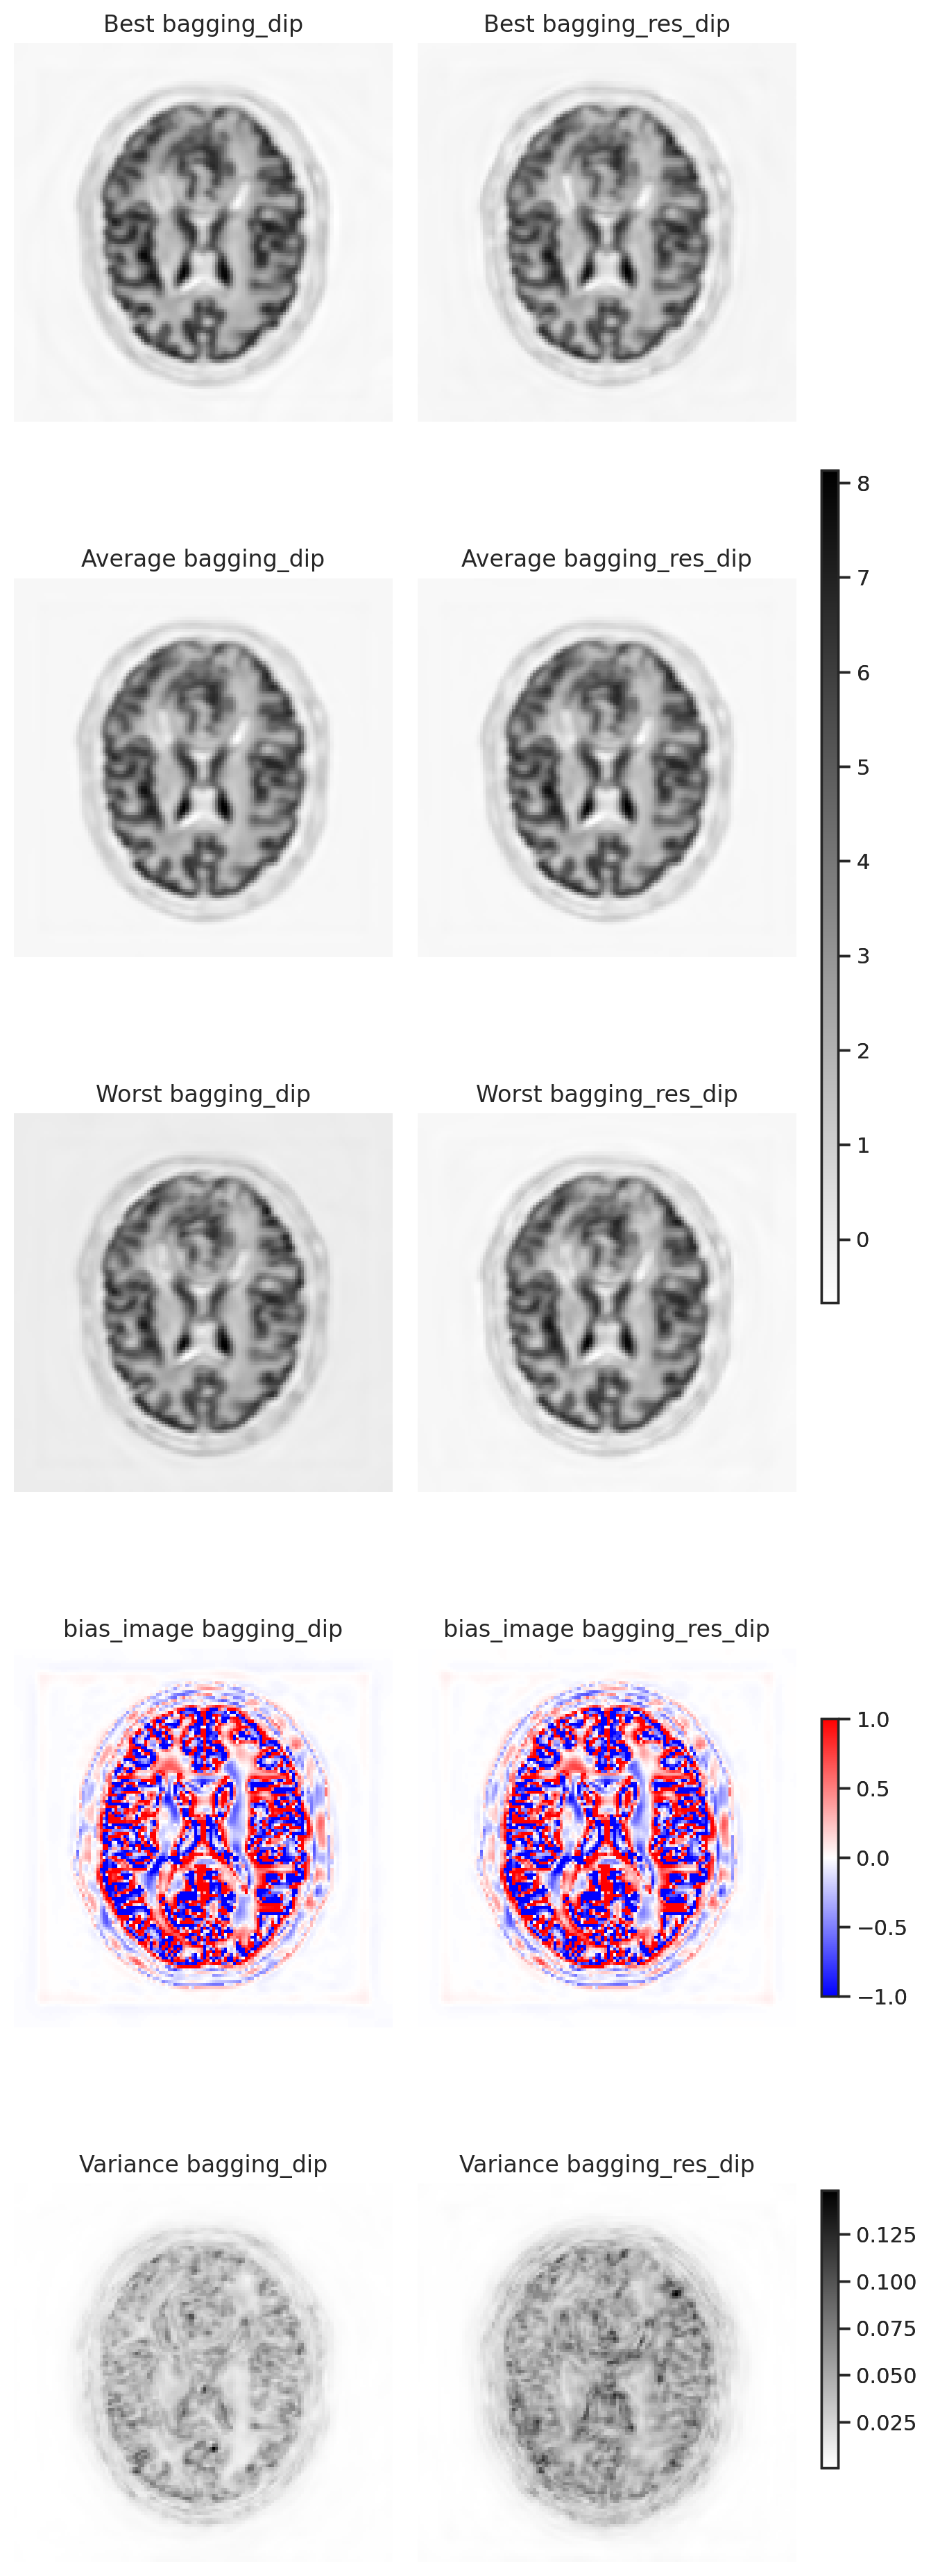

In [77]:
#plot image
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
fig, axs = plt.subplots(5, len(data), figsize=(3* len(data), 20))


# Create a custom colormap
cmap = LinearSegmentedColormap.from_list(
    'bias_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

fig.subplots_adjust(hspace=0.1)
# 根据上面获得的最佳和最差图片，找到并且打印出来
# 遍历每一行
for i, row in data.iterrows(): 
    # 构造文件路径
    best_image_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/{row['best_result_train']}/iters_{row['b_iteration']}.npy"
    average_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/average.npy"
    worst_image_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/{row['worst_result_train']}/iters_{row['w_iteration']}.npy"
    bias_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/bias.npy"
    variance_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['embed_dims']}_{row['depths']}_{row['skip']}/variance.npy"
    # best_image_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/{row['best_result_train']}/iters_{row['b_iteration']}.npy"
    # average_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/average.npy"
    # worst_image_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/{row['worst_result_train']}/iters_{row['w_iteration']}.npy"
    # bias_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/bias.npy"
    # variance_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['skip']}_{row['sigma_p']}/variance.npy"
    best_image = np.load(best_image_path)
    # best_image = np.clip(best_image, 0, 1)
    average_image = np.load(average_path)
    worst_image = np.load(worst_image_path)
    bias_image = np.load(bias_path)
    bias_image = np.clip(bias_image, -1, 1)
    variance_image = np.load(variance_path)

    axs[0, i].imshow(best_image, cmap='gray_r')
    axs[0, i].set_title(f"Best {row['model']}")
    axs[0, i].axis('off')
    axs[0, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[1, i].imshow(average_image, cmap='gray_r')
    axs[1, i].set_title(f"Average {row['model']}")
    axs[1, i].axis('off')
    axs[1, i].set_aspect('equal')  # 设置图像比例为1:1
        
    axs[2, i].imshow(worst_image, cmap='gray_r')
    axs[2, i].set_title(f"Worst {row['model']}")
    axs[2, i].axis('off')
    axs[2, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[3, i].imshow(bias_image, cmap=cmap, interpolation='nearest', origin='lower')
    axs[3, i].set_title(f"bias_image {row['model']}")
    axs[3, i].axis('off')
    axs[3, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[4, i].imshow(variance_image, cmap='gray_r')
    axs[4, i].set_title(f"Variance {row['model']}")
    axs[4, i].axis('off')
    axs[4, i].set_aspect('equal')  # 设置图像比例为1:1
  # 设置colorbar的位置和尺寸
    cax = fig.add_axes([1.0, 0.5, 0.02, 0.3])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[2, 0].images[0], cax=cax)   # 给best_image添加colorbar
    cax = fig.add_axes([1.0, 0.25, 0.02, 0.1])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[3, 0].images[0], cax=cax)
    cax = fig.add_axes([1.0, 0.08, 0.02, 0.1])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[4, 0].images[0], cax=cax)      
    
# 调整整个图像的布局和尺寸
plt.tight_layout()
plt.show();
# ADD fbc curves
# Gaussian noise 

In [97]:
data = grouped_df_v3
# data = data[data['model']=='Full_DIP'].reset_index(drop=True)
# data = data.drop(data[data['model']=='bagging_50'].index).reset_index(drop=True)
data = data.drop(data[data['model']=='non_res_act_2_7'].index).reset_index(drop=True)
data = data.drop(data[data['model']=='non_res_concat_2_7_0.1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='bilinear'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='res_act_concat_2_7'].index).reset_index(drop=True)
data = data.drop(data[data['model']=='non_res_act_add_v2'].index).reset_index(drop=True)
data = data.drop(data[data['model']=='res_act_add_v2'].index).reset_index(drop=True)
data = data.drop(data[data['model']=='res_act_2_7'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='res_act_concat_v2'].index).reset_index(drop=True)


# data = data.drop(data[data['model']=='gt_add_unform'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v3'].index).reset_idata = data.drop(data[data['model']=='bilinear_res'].index).reset_index(drop=True)ndex(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v0'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v2'].index).reset_index(drop=True)
# data = data.drop(data[data['sigma_p']=='10'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v2'].index).reset_index(drop=True)
# data = data.drop(data[(data['model']=='v0') & (data['sigma_p']=='5') ].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v3'].index).reset_index(drop=True)
data

,model,num_layers,embed_dims,skip,depths,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,bagging_dip,3,16,3,2,0,0.422042,0.457539,train_33,161,train_21,167
1,bagging_res_dip,3,16,3,2,0,0.430130,0.461866,train_33,179,train_1,187


In [102]:
filtered_data = pd.DataFrame()
df_base= df_n
data = data
# df_base['train'] = df_base['train'].astype('int64')
# data['sigma_p'] = data['sigma_p'].astype('int64')
print(df_base.dtypes)
print(data.dtypes)
# df_base['sigma_p'] = df_base['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
# 遍历 gdf_base 中的每一行
for i, row in data.iterrows():
    # 从 df_base 中提取相应的数据
    condition = (df_base['model'] == row['model']) & (df_base['num_layers'] == row['num_layers']) & (df_base['embed_dims'] == row['embed_dims']) & (df_base['skip'] == row['skip'])   & (df_base['train'] =='train_0')#row['best_result_train'])
    # condition = (df_base['model'] == row['model']) & (df_base['num_layers'] == row['num_layers']) & (df_base['num_channels'] == row['num_channels']) & (df_base['skip'] == row['skip'])   & (df_base['train'] == row['best_result_train'])
    extracted_data = df_base[condition]
    # print(condition)
    # 将提取的数据添加到 filtered_data 中
    filtered_data = filtered_data.append(extracted_data)
filtered_data
filtered_data.head()


model          object
num_layers      int64
embed_dims      int64
depths          int64
skip            int64
train          object
iteration       int64
loss          float64
mse           float64
psnr          float64
ssim          float64
dtype: object
model                  object
num_layers              int64
embed_dims              int64
skip                    int64
depths                  int64
level_5                 int64
best_mse              float64
worst_mse             float64
best_result_train      object
b_iteration             int64
worst_result_train     object
w_iteration             int64
dtype: object


,model,num_layers,embed_dims,depths,skip,train,iteration,loss,mse,psnr,ssim
40000,bagging_dip,3,16,2,3,train_0,0,7.541336,7.547713,6.784871,0.013042
40001,bagging_dip,3,16,2,3,train_0,1,55.501994,55.345984,-1.867836,0.005465
40002,bagging_dip,3,16,2,3,train_0,2,188.441179,188.625727,-7.192984,0.005418
40003,bagging_dip,3,16,2,3,train_0,3,12.026846,12.127480,4.725319,-0.046055
40004,bagging_dip,3,16,2,3,train_0,4,18.569152,18.552060,2.879104,0.044536
...,...,...,...,...,...,...,...,...,...,...,...
795,bagging_res_dip,3,16,2,3,train_0,795,0.035140,0.870721,16.164234,0.732067
796,bagging_res_dip,3,16,2,3,train_0,796,0.033786,0.861424,16.210856,0.742208
797,bagging_res_dip,3,16,2,3,train_0,797,0.033887,0.862263,16.206630,0.741160
798,bagging_res_dip,3,16,2,3,train_0,798,0.033220,0.867218,16.181741,0.743894


,model,num_layers,embed_dims,depths,skip,train,iteration,loss,mse,psnr,ssim
40000,bagging_dip,3,16,2,3,train_0,0,7.541336,7.547713,6.784871,0.013042
40001,bagging_dip,3,16,2,3,train_0,1,55.501994,55.345984,-1.867836,0.005465
40002,bagging_dip,3,16,2,3,train_0,2,188.441179,188.625727,-7.192984,0.005418
40003,bagging_dip,3,16,2,3,train_0,3,12.026846,12.127480,4.725319,-0.046055
40004,bagging_dip,3,16,2,3,train_0,4,18.569152,18.552060,2.879104,0.044536


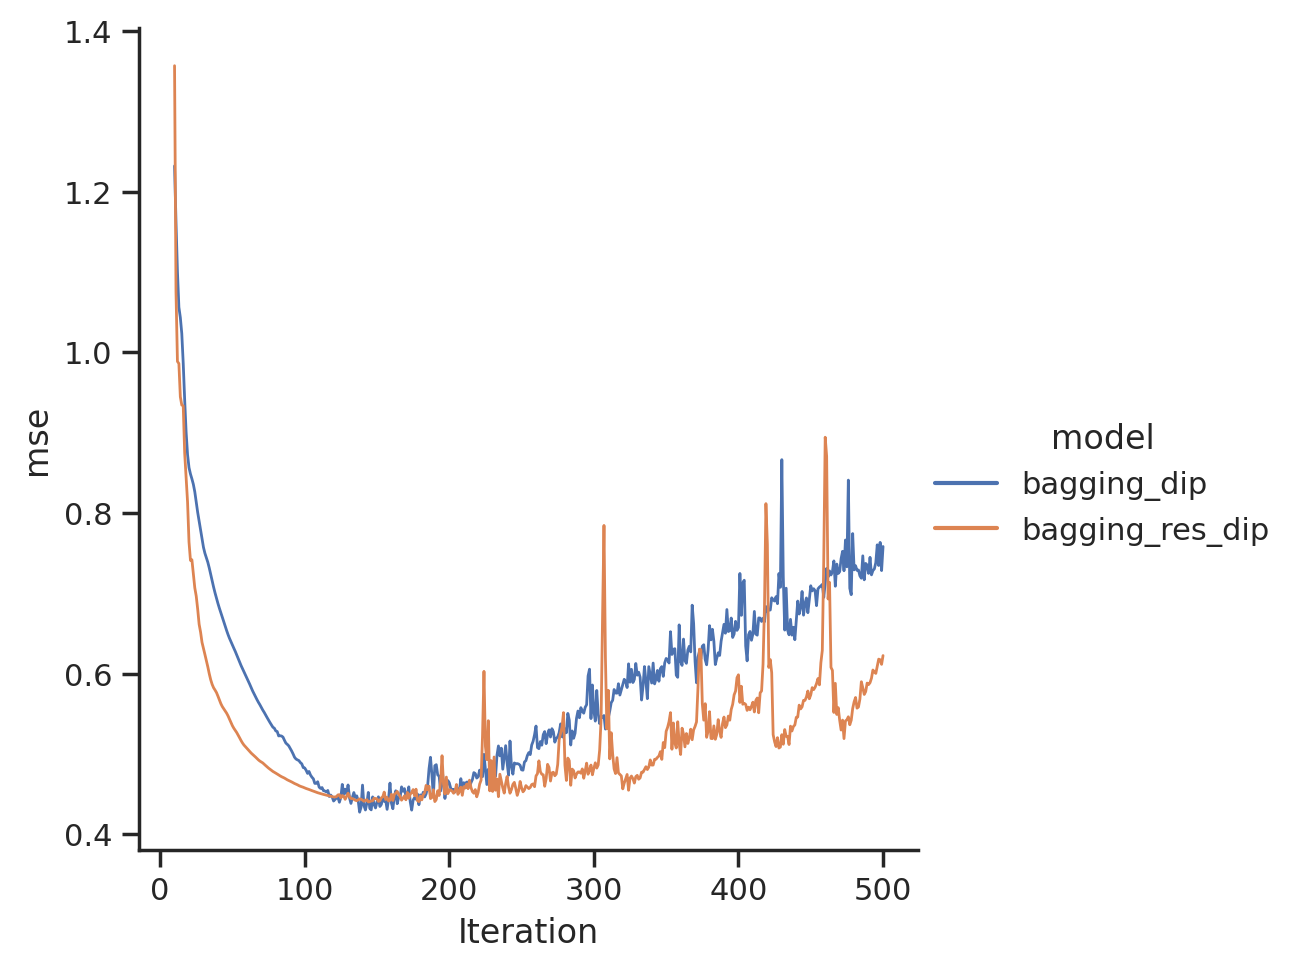

In [103]:
filtered_data = filtered_data [(filtered_data ["iteration"] >=10) & (filtered_data ["iteration"] <= 500)]
g = sns.relplot(
    data=filtered_data,
    hue='model',
    x='iteration',
    y='mse',
    kind='line',
    col=None,
    # style='sigma_p',
    dashes=False,
    ci=None,
    linewidth=1
)

# 设置坐标轴标签和标题
g.set(xlabel="Iteration", ylabel='mse')

# 显示图形
plt.show();


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import glob

# npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/noise_quick/Full_DIP_noise_v4/3_512_1/train_1/*.npy')
npy_files = glob.glob('/hdd/23_07/noise_test_uniform/Full_DIP_noise_v0/3_128_0/train_1/*.npy')
print(npy_files)
# npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/noise_quick/Res_DIP_backbone/3_128_0/train_0/*.npy')
npy_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]))
print(npy_files)
def show_image(file_index):
    data = np.load(npy_files[file_index])
    data = np.max(data)-data
    plt.imshow(data,cmap='gray')
    plt.title(f"Image {file_index + 1}")
    plt.axis('off')
    plt.show()
interact(show_image, file_index=IntSlider(min=0, max=len(npy_files)-1, step=1, value=0))


In [ ]:
for i,row in result_df.iterrows():
    try:
        # 删除文件
        os.remove(path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['sigma_p']}/average.npy")
        print(f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['sigma_p']}/average.npy 文件删除成功！")
    except OSError as e:
        print("文件删除失败:", e)

In [ ]:
import numpy as np
gt = np.load('/home/xzhang/Documents/我的模型/data/ground_truth/ground_truth_padded.npy')
ci = np.load('/home/xzhang/Documents/我的模型/data/corrupted_images/target_padded.npy')
gt.shape


In [ ]:
ci_r= np.max(ci) - ci
ci_r= np.max(ci) - ci
max_ci = np.max(ci)
min_ci = np.min(ci)
mean_ci = np.mean(ci)
std_ci = np.std(ci)
print(max_ci,min_ci,mean_ci, std_ci)
plt.imshow(ci_r,cmap='gray')
plt.show();

In [ ]:
gt_r= np.max(gt) - gt
max_gt = np.max(gt)
min_gt = np.min(gt)
mean_gt = np.mean(gt)
std_gt = np.std(gt)
print(max_gt,min_gt,mean_gt, std_gt)
plt.imshow(gt_r,cmap='gray')
plt.show();

In [ ]:
normalized_ci = ci / np.max(ci)  # 归一化 ci
max_normalized_ci = np.max(normalized_ci)
min_normalized_ci = np.min(normalized_ci)
mean_normalized_ci = np.mean(normalized_ci)
std_normalized_ci = np.std(normalized_ci)
print(max_normalized_ci,min_normalized_ci,mean_normalized_ci, std_normalized_ci)

In [ ]:
uniform_noise = np.random.uniform(0, 0.5, (128, 128,1))

print(np.std(uniform_noise))
added_uniform = normalized_gt + uniform_noise  # 归一化的 gt 加上 uniform 噪声
print(added_uniform.shape)
added_uniform = added_uniform * np.max(gt)  # 还原归一化的图像为原始尺度
added_uniform_r= np.max(added_uniform) - added_uniform
plt.imshow(added_uniform_r,cmap='gray')
plt.show()

In [ ]:
gaussian_noise = np.random.normal(0, 0.5, (128, 128,1))
mean_gt = np.mean(gt)
std_gt = np.std(gt)
print(std_gt)
normalized_gt = (gt - mean_gt) / std_gt  # 归一化 gt
std_gt = np.std(normalized_gt)
print(std_gt)
added_gaussian = normalized_gt + gaussian_noise  # 归一化的 gt 加上 Gaussian 噪声
added_gaussian = added_gaussian * std_gt + mean_gt  # 还原归一化的图像为原始尺度
print(added_gaussian.shape)
added_gaussian_r= np.max(added_gaussian) - added_gaussian
plt.imshow(added_gaussian_r,cmap='gray')
plt.show()

In [ ]:
suffix = '/home/xzhang/Documents/simplified_pipeline/data/corrupted_images/'

In [ ]:
np.save(suffix+'gaussian_noise.npy', gaussian_noise)
np.save(suffix+'uniform_noise.npy', uniform_noise)
np.save(suffix+'gt_add_unform.npy', added_uniform)
np.save(suffix+'gt_add_gaussian.npy', added_gaussian)

In [ ]:
import torch


In [ ]:
x = torch.distributions.Uniform(0,1).sample([1,1,128,128])
benoulli_p = 0.7
s_up = 2
s_down = 0

sample_mask = torch.distributions.Bernoulli(probs=benoulli_p).sample(x.shape)  # 使用伯努利分布进行采样,p概率为1，否则为0
sample_mask = sample_mask.float()  # 将采样结果转换为float类型，值为0或1
sampled_x = x * (sample_mask *s_up + (1 - sample_mask) * s_down)  # 根据伯努利采样结果对像素进行缩放，为1则放大，为0则缩小
out = sampled_x    
print(out.size())


# 新的研究方向，因为和其他的不一样，所以说重新开了一个


# 简单介绍一下分类：
- pixel-wise masked DIP ：
  - ratio_p 大于ratio\*up,小于ratio\*down

In [ ]:
df = pd.read_csv('/home/xzhang/Documents/simplified_pipeline/models_metrics_sampled.csv').iloc[:,1:]
df.head()

In [ ]:
grouped_df = df.groupby(['model', 'num_layers', 'num_channels',  'ratio_p','s_down','s_up','train']).agg({
    'loss': 'min',
    'mse': 'min',
    'psnr': 'max',
    'ssim': 'max'
}).reset_index()
grouped_df
grouped_df['model'].unique()

In [ ]:

data = grouped_df
data = data[data['ratio_p']==0.1].reset_index(drop=True)
# data = data[(data['ratio_p']==0.1)|(data['ratio_p']==0.9)].reset_index(drop=True)
data.head()
# data = data.drop(data[ (data['sigma_p']>2) ].index)
# # data = data.drop(data[ (data['sigma_p']>0.5) & (data['model']=='Full_DIP_noise_v0')].index)
# # data = data.drop(data[ (data['sigma_p']>4) & (data['model'] == 'v0')].index)
# data = data.drop(data[(data['s_down']<0.1)&(data['ratio_p']==0.9)].index)
# data = data.drop(data[(data['s_down']==0.1)&((data['s_down']==0.1))&(data['ratio_p']==0.9)].index)
# data = data.drop(data[(data['s_down']<0.1)&(data['ratio_p']==0.1)].index)
# data = data.drop(data[(data['s_down']==0.1)&((data['s_down']==0.1))&(data['ratio_p']==0.1)].index)
# data = data.drop(data[data['mse']>350].index)
# sns.catplot(x='model', y='mse',row=None,hue = 's_down',col= 's_up', data=data, kind='boxen')
sns.catplot(x='model', y='mse',row='ratio_p' ,hue ='s_down',col= 's_up', data=data, kind='boxen')
plt.suptitle('mse')
plt.show();

In [ ]:
grouped_df_v2 = df.groupby(['model', 'num_layers', 'num_channels',  'ratio_p','s_down','s_up','train']).apply(lambda x: x.loc[x['mse'].idxmin(),['iteration','mse']]).reset_index()
grouped_df_v2.columns = ['model', 'num_layers', 'num_channels', 'ratio_p','s_down','s_up','train','min_mse_iteration','min_mse']
# grouped_df_v2['sigma_p'] = grouped_df_v2['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
grouped_df_v2['s_down'] = grouped_df_v2['s_down'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
grouped_df_v2['s_up'] = grouped_df_v2['s_up'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
grouped_df_v2

In [ ]:
grouped_df_v3 = grouped_df_v2.groupby(['model', 'num_layers', 'num_channels',  'ratio_p','s_down','s_up']).apply(lambda x: pd.DataFrame({
                'best_mse' : [x.loc[x['min_mse'].idxmin(), 'min_mse']],
                'worst_mse' : [x.loc[x['min_mse'].idxmax(), 'min_mse']],
                'best_result_train': [x.loc[x['min_mse'].idxmin(), 'train']],
                'b_iteration': [x.loc[x['min_mse'].idxmin(), 'min_mse_iteration']],
                'worst_result_train': [x.loc[x['min_mse'].idxmax(), 'train']],
                'w_iteration': [x.loc[x['min_mse'].idxmax(), 'min_mse_iteration']]
            })).reset_index()
# grouped_df_v3['s_down'] = grouped_df_v3['s_down'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
# grouped_df_v3['s_up'] = grouped_df_v3['s_up'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
data = grouped_df_v3
data

In [ ]:

grouped_df = grouped_df_v2.groupby(['model', 'num_layers','num_channels','ratio_p','s_down','s_up'])
def get_file_list(group):
    files = []
    for train, iteration in zip(group['train'], group['min_mse_iteration']):
        files.append(f'{train}/iters_{iteration}.npy')
    return files
# 应用函数并创建新的DataFrame
result_df = grouped_df.apply(get_file_list).reset_index(name='files')
path_suffix ='/home/xzhang/Documents/simplified_pipeline/data/results/images/sampled/'
# path_suffix = '/hdd/23_07/pw_masked/'
for i,row in result_df.iterrows():
    average = np.zeros((128,128))
    for file in row['files']:
        file_name = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['ratio_p']}_{row['s_down']}_{row['s_up']}/{file}"
        average += np.load(file_name)
    average /= len(row['files'])
    np.save(file=path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['ratio_p']}_{row['s_down']}_{row['s_up']}/average.npy",arr=average)
    print(f"adding average image for {row['model']}/{row['num_layers']}_{row['num_channels']}_{row['ratio_p']}_{row['s_down']}_{row['s_up']}")

In [ ]:
data = grouped_df_v3
# data = data[data['ratio_p']==0.9].reset_index(drop=True)
data = data[data['ratio_p']==0.1].reset_index(drop=True)
data = data.drop(data[data['s_down']=='0'].index).reset_index(drop=True)
data = data.drop(data[(data['s_down']=='0.1')&(data['s_up']=='2')].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='ground_truth_padded'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='gt_add_unform'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v2'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v3'].index).reset_index(drop=True)
# data = data.drop(data[data['sigma_p']=='10'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v1'].index).reset_index(drop=True)
# # data = data.drop(data[data['model']=='v2'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v3'].index).reset_index(drop=True)
data

In [ ]:
#plot image
fig, axs = plt.subplots(3, len(data), figsize=(5 * len(data), 15))
fig.subplots_adjust(hspace=0.3)
# 根据上面获得的最佳和最差图片，找到并且打印出来
# 遍历每一行
for i, row in data.iterrows():
    
    # 构造文件路径
    best_image_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['ratio_p']}_{row['s_down']}_{row['s_up']}/{row['best_result_train']}/iters_{row['b_iteration']}.npy"
    average_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['ratio_p']}_{row['s_down']}_{row['s_up']}/average.npy"
    worst_image_path = path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['ratio_p']}_{row['s_down']}_{row['s_up']}/{row['worst_result_train']}/iters_{row['w_iteration']}.npy"

    best_image = np.load(best_image_path)
    average_image = np.load(average_path)
    worst_image = np.load(worst_image_path)
    # print(best_image.shape)
    # print(worst_image.shape)
    best_image = np.max(best_image) - best_image
    average_image = np.max(average_image)-average_image
    worst_image = np.max(worst_image) - worst_image


    axs[0,i].imshow(best_image, cmap='gray');
    axs[0,i].set_title(f"Best result from {row['model']}\nNum Layers: {row['num_layers']}\nNum Channels: {row['num_channels']}\nSigma: {row['ratio_p']}_{row['s_down']}_{row['s_up']}")
    axs[0,i].axis('off')
    
    axs[1,i].imshow(average_image, cmap='gray');
    axs[1,i].set_title(f"average_image from {row['model']}\nNum Layers: {row['num_layers']}\nNum Channels: {row['num_channels']}\nSigma: {row['ratio_p']}_{row['s_down']}_{row['s_up']}")
    axs[1,i].axis('off')
        
    axs[2,i].imshow(worst_image, cmap='gray');
    axs[2,i].set_title(f"Worst result from {row['model']}\nNum Layers: {row['num_layers']}\nNum Channels: {row['num_channels']}\nSigma: {row['ratio_p']}_{row['s_down']}_{row['s_up']}")
    axs[2,i].axis('off')
# 调整整个图像的布局和尺寸
plt.tight_layout()
plt.show();

In [ ]:
data = grouped_df_v3
# data = data[data['ratio_p']==0.1].reset_index(drop=True)
data = data.drop(data[data['s_down']=='0'].index).reset_index(drop=True)
# data = data.drop(data[data['s_up']=='2'].index).reset_index(drop=True)
data['ratio_p'] = data['ratio_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
# data = data.drop(data[data['model']=='ground_truth_padded'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='gt_add_unform'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v3'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v0'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v1'].index).reset_index(drop=True)
# data = data.drop(data[data['sigma_p']=='10'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v2'].index).reset_index(drop=True)
# data = data.drop(data[(data['model']=='v0') & (data['sigma_p']=='5') ].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v3'].index).reset_index(drop=True)

data

In [198]:
filtered_data = pd.DataFrame()
df= df

# data = data.drop('level_6',axis=1).reset_index(drop=True)

print(df.dtypes,data.dtypes)
df.iloc[:,:5].astype(data.iloc[:,:5].dtypes)
print(df.dtypes,data.dtypes)
# df['ratio_p'] = df['ratio_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
# df['s_down'] = df['s_down'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
# df['s_up'] = df['s_up'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
data

df[(df['model'] =='sampled_DIP') & (df['num_layers'] == 3) & (df['num_channels'] == 128) & (df['ratio_p'] == 0.1) &(df['s_down'] == 0.1)&(df['s_up'] == 1) ]
# 遍历 gdf 中的每一行
for i, row in data.iterrows():
    # 从 df 中提取相应的数据
    condition = (df['model'] == row['model']) & (df['num_layers'] == row['num_layers']) & (df['num_channels'] == row['num_channels']) & (df['ratio_p'] == row['ratio_p']) &(df['s_down'] == row['s_down'])&(df['s_up'] == row['s_up'])  & (df['train'] == row['best_result_train'])
    extracted_data = df[condition]

    # 将提取的数据添加到 filtered_data 中
    filtered_data = filtered_data.append(extracted_data)
filtered_data


model          object
num_layers      int64
embed_dims      int64
depths          int64
skip            int64
train          object
iteration       int64
loss          float64
mse           float64
psnr          float64
ssim          float64
skip_type      object
res            object
dtype: object model                  object
num_layers              int64
embed_dims              int64
skip                    int64
depths                  int64
level_5                 int64
best_mse              float64
worst_mse             float64
best_result_train      object
b_iteration             int64
worst_result_train     object
w_iteration             int64
dtype: object


,model,num_layers,embed_dims,depths,skip
0,non_res_act_concat_2_7,4,24,2,4
1,non_res_act_concat_2_7,4,24,2,4
2,non_res_act_concat_2_7,4,24,2,4
3,non_res_act_concat_2_7,4,24,2,4
4,non_res_act_concat_2_7,4,24,2,4
...,...,...,...,...,...
232912,bilinear,4,32,2,4
232913,bilinear,4,32,2,4
232914,bilinear,4,32,2,4
232915,bilinear,4,32,2,4


model          object
num_layers      int64
embed_dims      int64
depths          int64
skip            int64
train          object
iteration       int64
loss          float64
mse           float64
psnr          float64
ssim          float64
skip_type      object
res            object
dtype: object model                  object
num_layers              int64
embed_dims              int64
skip                    int64
depths                  int64
level_5                 int64
best_mse              float64
worst_mse             float64
best_result_train      object
b_iteration             int64
worst_result_train     object
w_iteration             int64
dtype: object


,model,num_layers,embed_dims,skip,depths,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,bilinear,3,32,3,2,0,0.431082,0.546890,train_28,413,train_15,675
1,bilinear,4,32,4,2,0,0.441748,0.525278,train_7,511,train_20,526
2,non_res_act_2_7,4,24,4,2,0,0.479421,0.588144,train_39,139,train_7,68
3,non_res_act_concat_2_7,4,24,4,2,0,0.476114,0.581932,train_13,42,train_46,112
4,res_act_2_7,4,24,4,2,0,0.502470,0.689058,train_13,49,train_10,396
5,res_act_concat_2_7,4,24,4,2,0,0.461940,0.652331,train_27,56,train_9,153
6,swin_unetr_add,4,24,4,2,0,0.446682,0.618770,train_43,61,train_34,121


KeyError: 'num_channels'

In [64]:
filtered_data = pd.read_csv("/home/xzhang/Documents/simplified_pipeline/metrics/skip_connection/fbc.csv")
filtered_data

,Unnamed: 0,iteration,lowest,low,medium,high,highest
0,0,0,1.000000,1.000000,1.000000,0.999772,0.999765
1,0,1,1.000000,1.000000,0.997931,0.999036,0.997655
2,0,2,1.000000,0.997985,0.993727,0.988649,0.978990
3,0,3,0.999459,0.991991,0.980401,0.960887,0.957554
4,0,4,0.998909,0.984907,0.984456,0.956781,0.932452
...,...,...,...,...,...,...,...
795,0,795,1.000000,0.995764,0.972120,0.933281,0.891662
796,0,796,1.000000,0.996670,0.972836,0.932087,0.893957
797,0,797,1.000000,0.995093,0.974720,0.931024,0.898986
798,0,798,1.000000,0.995603,0.974889,0.929409,0.895692


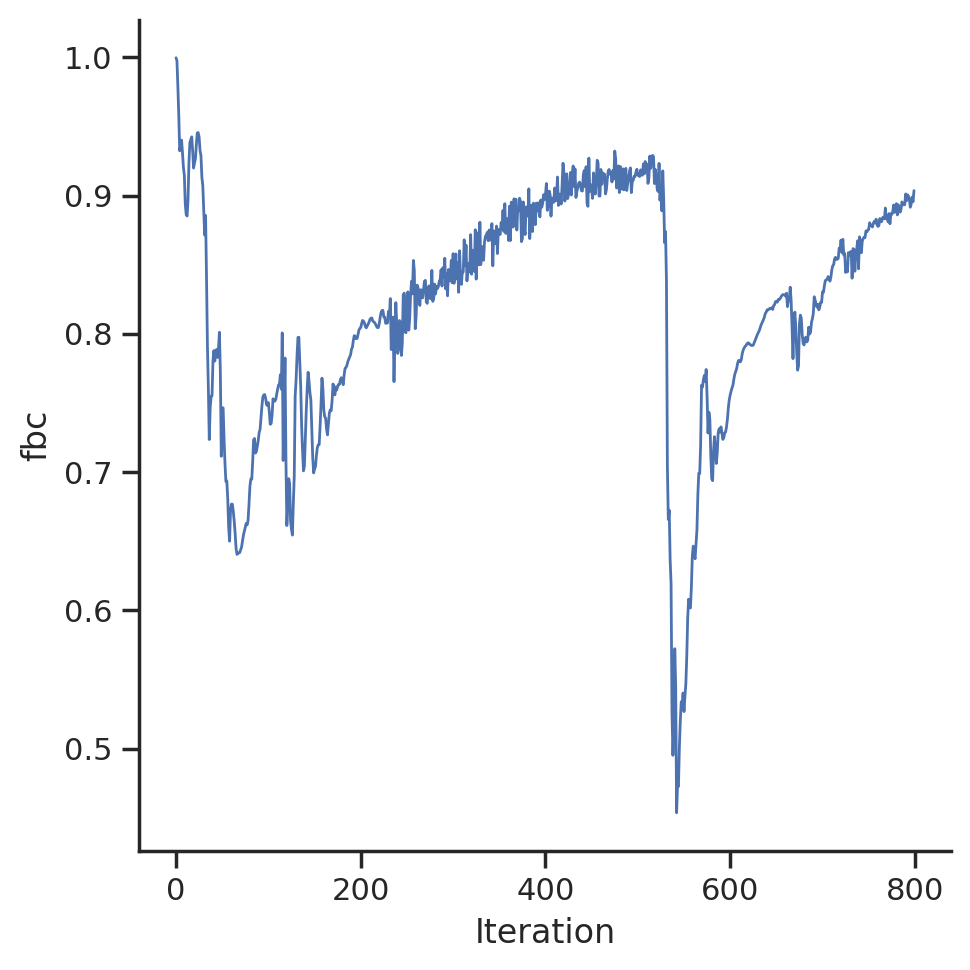

In [69]:

g = sns.relplot(
    data=filtered_data,
    hue=None,
    x='iteration',
    y='highest',
    kind='line',
    col=None,
    row=None,
    # style='sigma_p',
    dashes=False,
    ci=None,
    linewidth=1
)

# 设置坐标轴标签和标题
g.set(xlabel="Iteration", ylabel='fbc')

# 显示图形
plt.show();

In [ ]:
filtered_data = pd.read_csv("/home/xzhang/Documents/simplified_pipeline/metrics/skip_connection/fbc.csv")

g = sns.relplot(
    data=filtered_data,
    hue=None,
    x='iteration',
    y='low',
    kind='line',
    col=None,
    row=None,
    # style='sigma_p',
    dashes=False,
    ci=None,
    linewidth=1
)

# 设置坐标轴标签和标题
g.set(xlabel="Iteration", ylabel='fbc')

# 显示图形
plt.show();

In [ ]:
filtered_data = filtered_data [(filtered_data ["iteration"] >=10) & (filtered_data ["iteration"] <= 3000)]
g = sns.relplot(
    data=filtered_data,
    hue='s_down',
    x='iteration',
    y='mse',
    kind='line',
    col='s_up',
    row='ratio_p',
    # style='sigma_p',
    dashes=False,
    ci=None,
    linewidth=1
)

# 设置坐标轴标签和标题
g.set(xlabel="Iteration", ylabel='psnr')

# 显示图形
plt.show();

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import glob

# npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/noise_quick/Full_DIP_noise_v4/3_512_1/train_1/*.npy')
# npy_files = glob.glob('/hdd/23_07/noise_test_uniform/Full_DIP_noise_v0/3_128_0/train_1/*.npy')

npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/sampled/sampled_DIP/3_128_0.1_0.1_1/train_2/*.npy')
print(npy_files)
# npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/noise_quick/Res_DIP_backbone/3_128_0/train_0/*.npy')
npy_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]))
print(npy_files)
def show_image(file_index):
    data = np.load(npy_files[file_index])
    data = np.max(data)-data
    plt.imshow(data,cmap='gray')
    plt.title(f"Image {file_index + 1}")
    plt.axis('off')
    plt.show()
interact(show_image, file_index=IntSlider(min=0, max=len(npy_files)-1, step=1, value=0))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import glob

# npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/noise_quick/Full_DIP_noise_v4/3_512_1/train_1/*.npy')
npy_files = glob.glob('/hdd/23_07/noise_test_uniform/Full_DIP_noise_v0/3_128_0/train_1/*.npy')
print(npy_files)
# npy_files = glob.glob('/home/xzhang/Documents/simplified_pipeline/data/results/images/noise_quick/Res_DIP_backbone/3_128_0/train_0/*.npy')
npy_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]))
print(npy_files)
def show_image(file_index):
    data = np.load(npy_files[file_index])
    data = np.max(data)-data
    plt.imshow(data,cmap='gray')
    plt.title(f"Image {file_index + 1}")
    plt.axis('off')
    plt.show()
interact(show_image, file_index=IntSlider(min=0, max=len(npy_files)-1, step=1, value=0))

In [ ]:
for i,row in result_df.iterrows():
    try:
        # 删除文件
        os.remove(path_suffix + f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['sigma_p']}/average.npy")
        print(f"{row['model']}/{row['num_layers']}_{row['num_channels']}_{row['sigma_p']}/average.npy 文件删除成功！")
    except OSError as e:
        print("文件删除失败:", e)

In [ ]:
import torch
from torch import nn

In [ ]:

L_relu = 0.2
num_channel =[16,32,64,128]# num_channels # 16 32 64 128 
pad = [0,0]
deep1 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(1, num_channel[0], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[0]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[0], num_channel[0], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[0]),
            nn.LeakyReLU(L_relu))

down1 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[0], num_channel[0], 3, stride=(2, 2), padding=pad[1]),
            nn.BatchNorm2d(num_channel[0]),
            nn.LeakyReLU(L_relu))

deep2 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[0], num_channel[1], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[1]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[1], num_channel[1], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[1]),
            nn.LeakyReLU(L_relu))

down2 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[1], num_channel[1], 3, stride=(2, 2), padding=pad[1]),
            nn.BatchNorm2d(num_channel[1]),
            nn.LeakyReLU(L_relu))

deep3 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[1], num_channel[2], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[2]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[2], num_channel[2], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[2]),
            nn.LeakyReLU(L_relu))

down3 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[2], num_channel[2], 3, stride=(2, 2), padding=pad[1]),
            nn.BatchNorm2d(num_channel[2]),
            nn.LeakyReLU(L_relu))

deep4 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[2], num_channel[3], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[3]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[3], num_channel[3], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[3]),
            nn.LeakyReLU(L_relu))

up1 = nn.Sequential(nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=False),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[3], num_channel[2], 3, stride=(1, 1), padding=pad[0]),
            nn.BatchNorm2d(num_channel[2]),
            nn.LeakyReLU(L_relu))

deep5 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[2]+num_channel[2], num_channel[2], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[2]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[2], num_channel[2], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[2]),
            nn.LeakyReLU(L_relu))

up2 = nn.Sequential(nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=False),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[2], num_channel[1], 3, stride=(1, 1), padding=pad[0]),
            nn.BatchNorm2d(num_channel[1]),
            nn.LeakyReLU(L_relu))

deep6 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[1]+num_channel[1], num_channel[1], (3, 3), stride=1, padding=pad[0]),
            nn.BatchNorm2d(num_channel[1]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[1], num_channel[1], (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(num_channel[1]),
            nn.LeakyReLU(L_relu))

up3 = nn.Sequential(nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=False),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[1], num_channel[0], 3, stride=(1, 1), padding=pad[0]),
            nn.BatchNorm2d(num_channel[0]),
            nn.LeakyReLU(L_relu))

deep7 = nn.Sequential(nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[0]+num_channel[0], num_channel[0], (3, 3), stride=1, padding=pad[0]),
            nn.BatchNorm2d(num_channel[0]),
            nn.LeakyReLU(L_relu),
            nn.ReplicationPad2d(1),
            nn.Conv2d(num_channel[0], 1, (3, 3), stride=1, padding=pad[1]),
            nn.BatchNorm2d(1))

positivity = nn.ReLU()



x = torch.rand((1,1,128,128))

# Encoder
out1 = deep1(x)
out = down1(out1)
out2 = deep2(out)
out = down2(out2)
out3 = deep3(out)
out = down3(out3)
out = deep4(out)

# Decoder
out = up1(out)
out_skip1 = torch.cat([out3,out],dim=1)
print(out.size(),out3.size(),out_skip1.size())
out = deep5(out_skip1)

out = up2(out)
out_skip2 = torch.cat([out2,out],dim=1)
print(out.size(),out2.size(),out_skip2.size())
out = deep6(out_skip2)


out = up3(out)

out_skip3 =torch.cat([out1,out],dim=1) 
print(out.size(),out1.size(),out_skip3.size())
out = deep7(out_skip3)

out = positivity(out)

print(out.size())

In [ ]:
plt.imshow(np.max(corrupted_image)-corrupted_image,cmap='gray')
plt.show()

In [ ]:

plt.imshow(np.max(ground_truth)-ground_truth,cmap='gray')
plt.show()

In [50]:
import torch

In [58]:
x = torch.randn(1,3,128,128)
y = torch.mean(x,dim=(0,2,3),keepdim=True)
print(y.shape)

torch.Size([1, 3, 1, 1])


# swin_unetr 研究部分：


In [52]:
df_n = pd.read_csv('/home/xzhang/Documents/simplified_pipeline/metrics/swin_unet/Swin_unet_brain.csv').iloc[:,1:]
df_n

,model,embed_dims,depths,num_heads,sigma_p,train,iteration,loss,mse,psnr,ssim
0,swin_unet,48,4,3,0,train_0,0,116.743503,116.810063,-5.111778,0.000469
1,swin_unet,48,4,3,0,train_0,1,79.330677,79.248380,-3.426879,0.007630
2,swin_unet,48,4,3,0,train_0,2,61.308181,61.235364,-2.306998,0.003332
3,swin_unet,48,4,3,0,train_0,3,17.899860,17.883908,3.038401,-0.008227
4,swin_unet,48,4,3,0,train_0,4,21.230845,21.233720,2.292764,0.012328
...,...,...,...,...,...,...,...,...,...,...,...
23995,swin_unet,48,2,6,0,train_9,595,0.290704,0.701270,17.104170,0.583298
23996,swin_unet,48,2,6,0,train_9,596,0.283578,0.691591,17.164529,0.634766
23997,swin_unet,48,2,6,0,train_9,597,0.275724,0.695348,17.141004,0.608213
23998,swin_unet,48,2,6,0,train_9,598,0.271812,0.692079,17.161466,0.634948


In [53]:
grouped_df = df_n.groupby(['model', 'embed_dims', 'depths', 'num_heads',  'sigma_p','train']).agg({
    'loss': 'min',
    'mse': 'min',
    'psnr': 'max',
    'ssim': 'max'
    
}).reset_index()
grouped_df.head()
grouped_df['model'].unique()

,model,embed_dims,depths,num_heads,sigma_p,train,loss,mse,psnr,ssim
0,swin_unet,48,2,3,0,train_0,0.389619,0.636345,17.526096,0.693911
1,swin_unet,48,2,3,0,train_1,0.494103,0.688278,17.185383,0.598879
2,swin_unet,48,2,3,0,train_2,0.431225,0.637444,17.518608,0.651204
3,swin_unet,48,2,3,0,train_3,0.492467,0.678128,17.249907,0.645556
4,swin_unet,48,2,3,0,train_4,0.373652,0.638036,17.514574,0.689520


array(['swin_unet'], dtype=object)

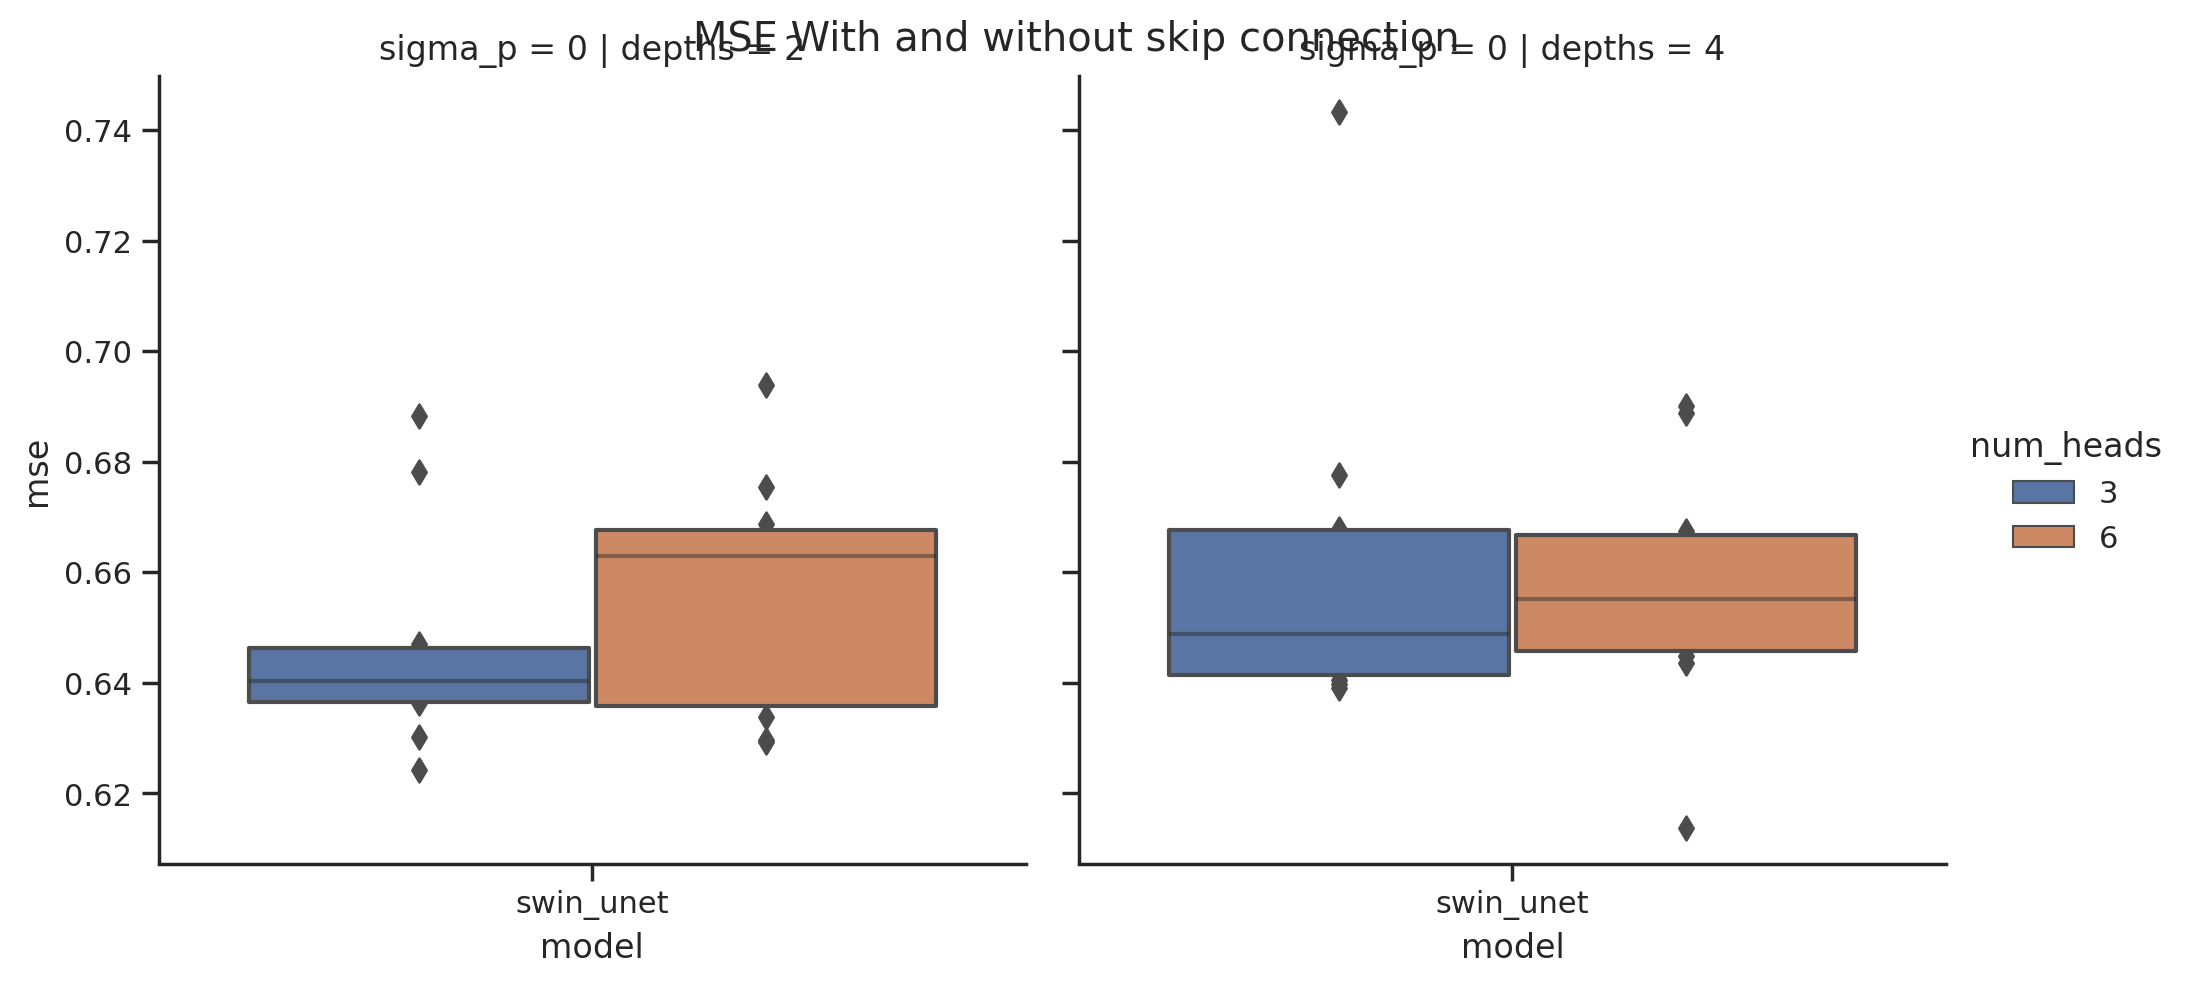

In [54]:
data = grouped_df

# data = data.drop(data[ (data['mse']>30000) ].index)
# data = data.drop(data[ (data['model']=='Swin_Unetr_pre' )].index)
# data = data.drop(data[ (data['sigma_p']==0.1 )].index)
data["model"] = data["model"].replace("non_res_act_2_7", "n_res")
data["model"] = data["model"].replace("res_act_2_7", "res")
data["model"] = data["model"].replace("non_res_act_concat_2_7", "n_res_c")
data["model"] = data["model"].replace("res_act_concat_2_7", "res_c")
sns.catplot(x='model', y='mse',row='sigma_p',hue ='num_heads',col='depths', data=data, kind='boxen')
baseline_value = psnr_baseline #-50  # 假设baseline值为50
# plt.axhline(y = 0.5, color='b', linestyle='--', label='Baseline')
# plt.text(0.2,16, f'Baseline = {psnr_baseline:.2f}', color='b', fontsize=12)  # 添加文字说明
plt.suptitle('MSE With and without skip connection')
plt.show();

In [111]:
grouped_df_v2 = df_n.groupby(['model', 'embed_dims', 'depths', 'num_heads',  'sigma_p','train']).apply(lambda x: x.loc[x['mse'].idxmin(),['iteration','mse']]).reset_index()
grouped_df_v2.columns = ['model', 'embed_dims', 'depths', 'num_heads',  'sigma_p','train','min_mse_iteration','min_mse']
grouped_df_v2['sigma_p'] = grouped_df_v2['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
grouped_df_v2

,model,embed_dims,depths,num_heads,sigma_p,train,min_mse_iteration,min_mse
0,swin_unet,48,2,3,0,train_0,520,0.636345
1,swin_unet,48,2,3,0,train_1,585,0.688278
2,swin_unet,48,2,3,0,train_2,589,0.637444
3,swin_unet,48,2,3,0,train_3,588,0.678128
4,swin_unet,48,2,3,0,train_4,525,0.638036
5,swin_unet,48,2,3,0,train_5,590,0.642666
6,swin_unet,48,2,3,0,train_6,536,0.644208
7,swin_unet,48,2,3,0,train_7,419,0.624175
8,swin_unet,48,2,3,0,train_8,458,0.630268
9,swin_unet,48,2,3,0,train_9,564,0.647005


In [112]:
grouped_df_v3 = grouped_df_v2.groupby(['model', 'embed_dims', 'depths', 'num_heads',   'sigma_p']).apply(lambda x: pd.DataFrame({
                'best_mse' : [x.loc[x['min_mse'].idxmin(), 'min_mse']],
                'worst_mse' : [x.loc[x['min_mse'].idxmax(), 'min_mse']],
                'best_result_train': [x.loc[x['min_mse'].idxmin(), 'train']],
                'b_iteration': [x.loc[x['min_mse'].idxmin(), 'min_mse_iteration']],
                'worst_result_train': [x.loc[x['min_mse'].idxmax(), 'train']],
                'w_iteration': [x.loc[x['min_mse'].idxmax(), 'min_mse_iteration']]
            })).reset_index()
# grouped_df_v3['sigma_p'] = grouped_df_v3['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
data = grouped_df_v3
data

,model,embed_dims,depths,num_heads,sigma_p,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,swin_unet,48,2,3,0,0,0.624175,0.688278,train_7,419,train_1,585
1,swin_unet,48,2,6,0,0,0.629332,0.693924,train_1,415,train_4,584
2,swin_unet,48,4,3,0,0,0.639104,0.743312,train_4,535,train_3,503
3,swin_unet,48,4,6,0,0,0.613797,0.690089,train_8,495,train_1,598


In [115]:
path_suffix = '/home/xzhang/Documents/simplified_pipeline/data/results/images/Swin_Unet_brain/'

In [116]:
grouped_df = grouped_df_v2.groupby(['model', 'embed_dims', 'depths', 'num_heads','sigma_p'])
def get_file_list(group):
    files = []
    for train, iteration in zip(group['train'], group['min_mse_iteration']):
        files.append(f'{train}/iters_{iteration}.npy')
    return files
# 应用函数并创建新的DataFrame
result_df = grouped_df.apply(get_file_list).reset_index(name='files')
# path_suffix = '/home/xzhang/Documents/simplified_pipeline/data/results/images/normal_input/'

# path_suffix = '/hdd/23_07/noise_test/'
for i,row in result_df.iterrows():
    average = np.zeros((128,128))
    for file in row['files']:
        file_name = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/{file}"
        average += np.load(file_name)
    average /= len(row['files'])
    bias = average - ground_truth[:,:,0] 
    print(bias.shape)
   
    np.save(file=path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/bias.npy",arr=bias)
    np.save(file=path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/average.npy",arr=average)
    print(f"adding average image for {row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}")
    variance = np.zeros((128,128))
    for file in row['files']:
        file_name = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/{file}"
        variance += (np.load(file_name)-average)**2
    variance /= (len(row['files'])-1)
    np.save(file=path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/variance.npy",arr=variance)
    print(f"adding variance image for {row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}")

(128, 128)
adding average image for swin_unet/48_2_3_0
adding variance image for swin_unet/48_2_3_0
(128, 128)
adding average image for swin_unet/48_2_6_0
adding variance image for swin_unet/48_2_6_0
(128, 128)
adding average image for swin_unet/48_4_3_0
adding variance image for swin_unet/48_4_3_0
(128, 128)
adding average image for swin_unet/48_4_6_0
adding variance image for swin_unet/48_4_6_0


In [117]:
data = grouped_df_v3#pd.concat([grouped_df_v3,grouped_df_v3],axis=0)
# data = data[data['ratio_p']==0.9].reset_index(drop=True)
# data = data[data['model']==0.1].reset_index(drop=True)
# data = data.drop(data[data['depths']==1].index).reset_index(drop=True)
# data = data.drop(data[data['sigma_p']=='0.1'].index).reset_index(drop=True)
# data = data.drop(data[data['s_down']=='0'].index).reset_index(drop=True)
# data = data.drop(data[(data['s_down']=='0.1')&(data['s_up']=='2')].index).reset_index(drop=True)

data

,model,embed_dims,depths,num_heads,sigma_p,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,swin_unet,48,2,3,0,0,0.624175,0.688278,train_7,419,train_1,585
1,swin_unet,48,2,6,0,0,0.629332,0.693924,train_1,415,train_4,584
2,swin_unet,48,4,3,0,0,0.639104,0.743312,train_4,535,train_3,503
3,swin_unet,48,4,6,0,0,0.613797,0.690089,train_8,495,train_1,598


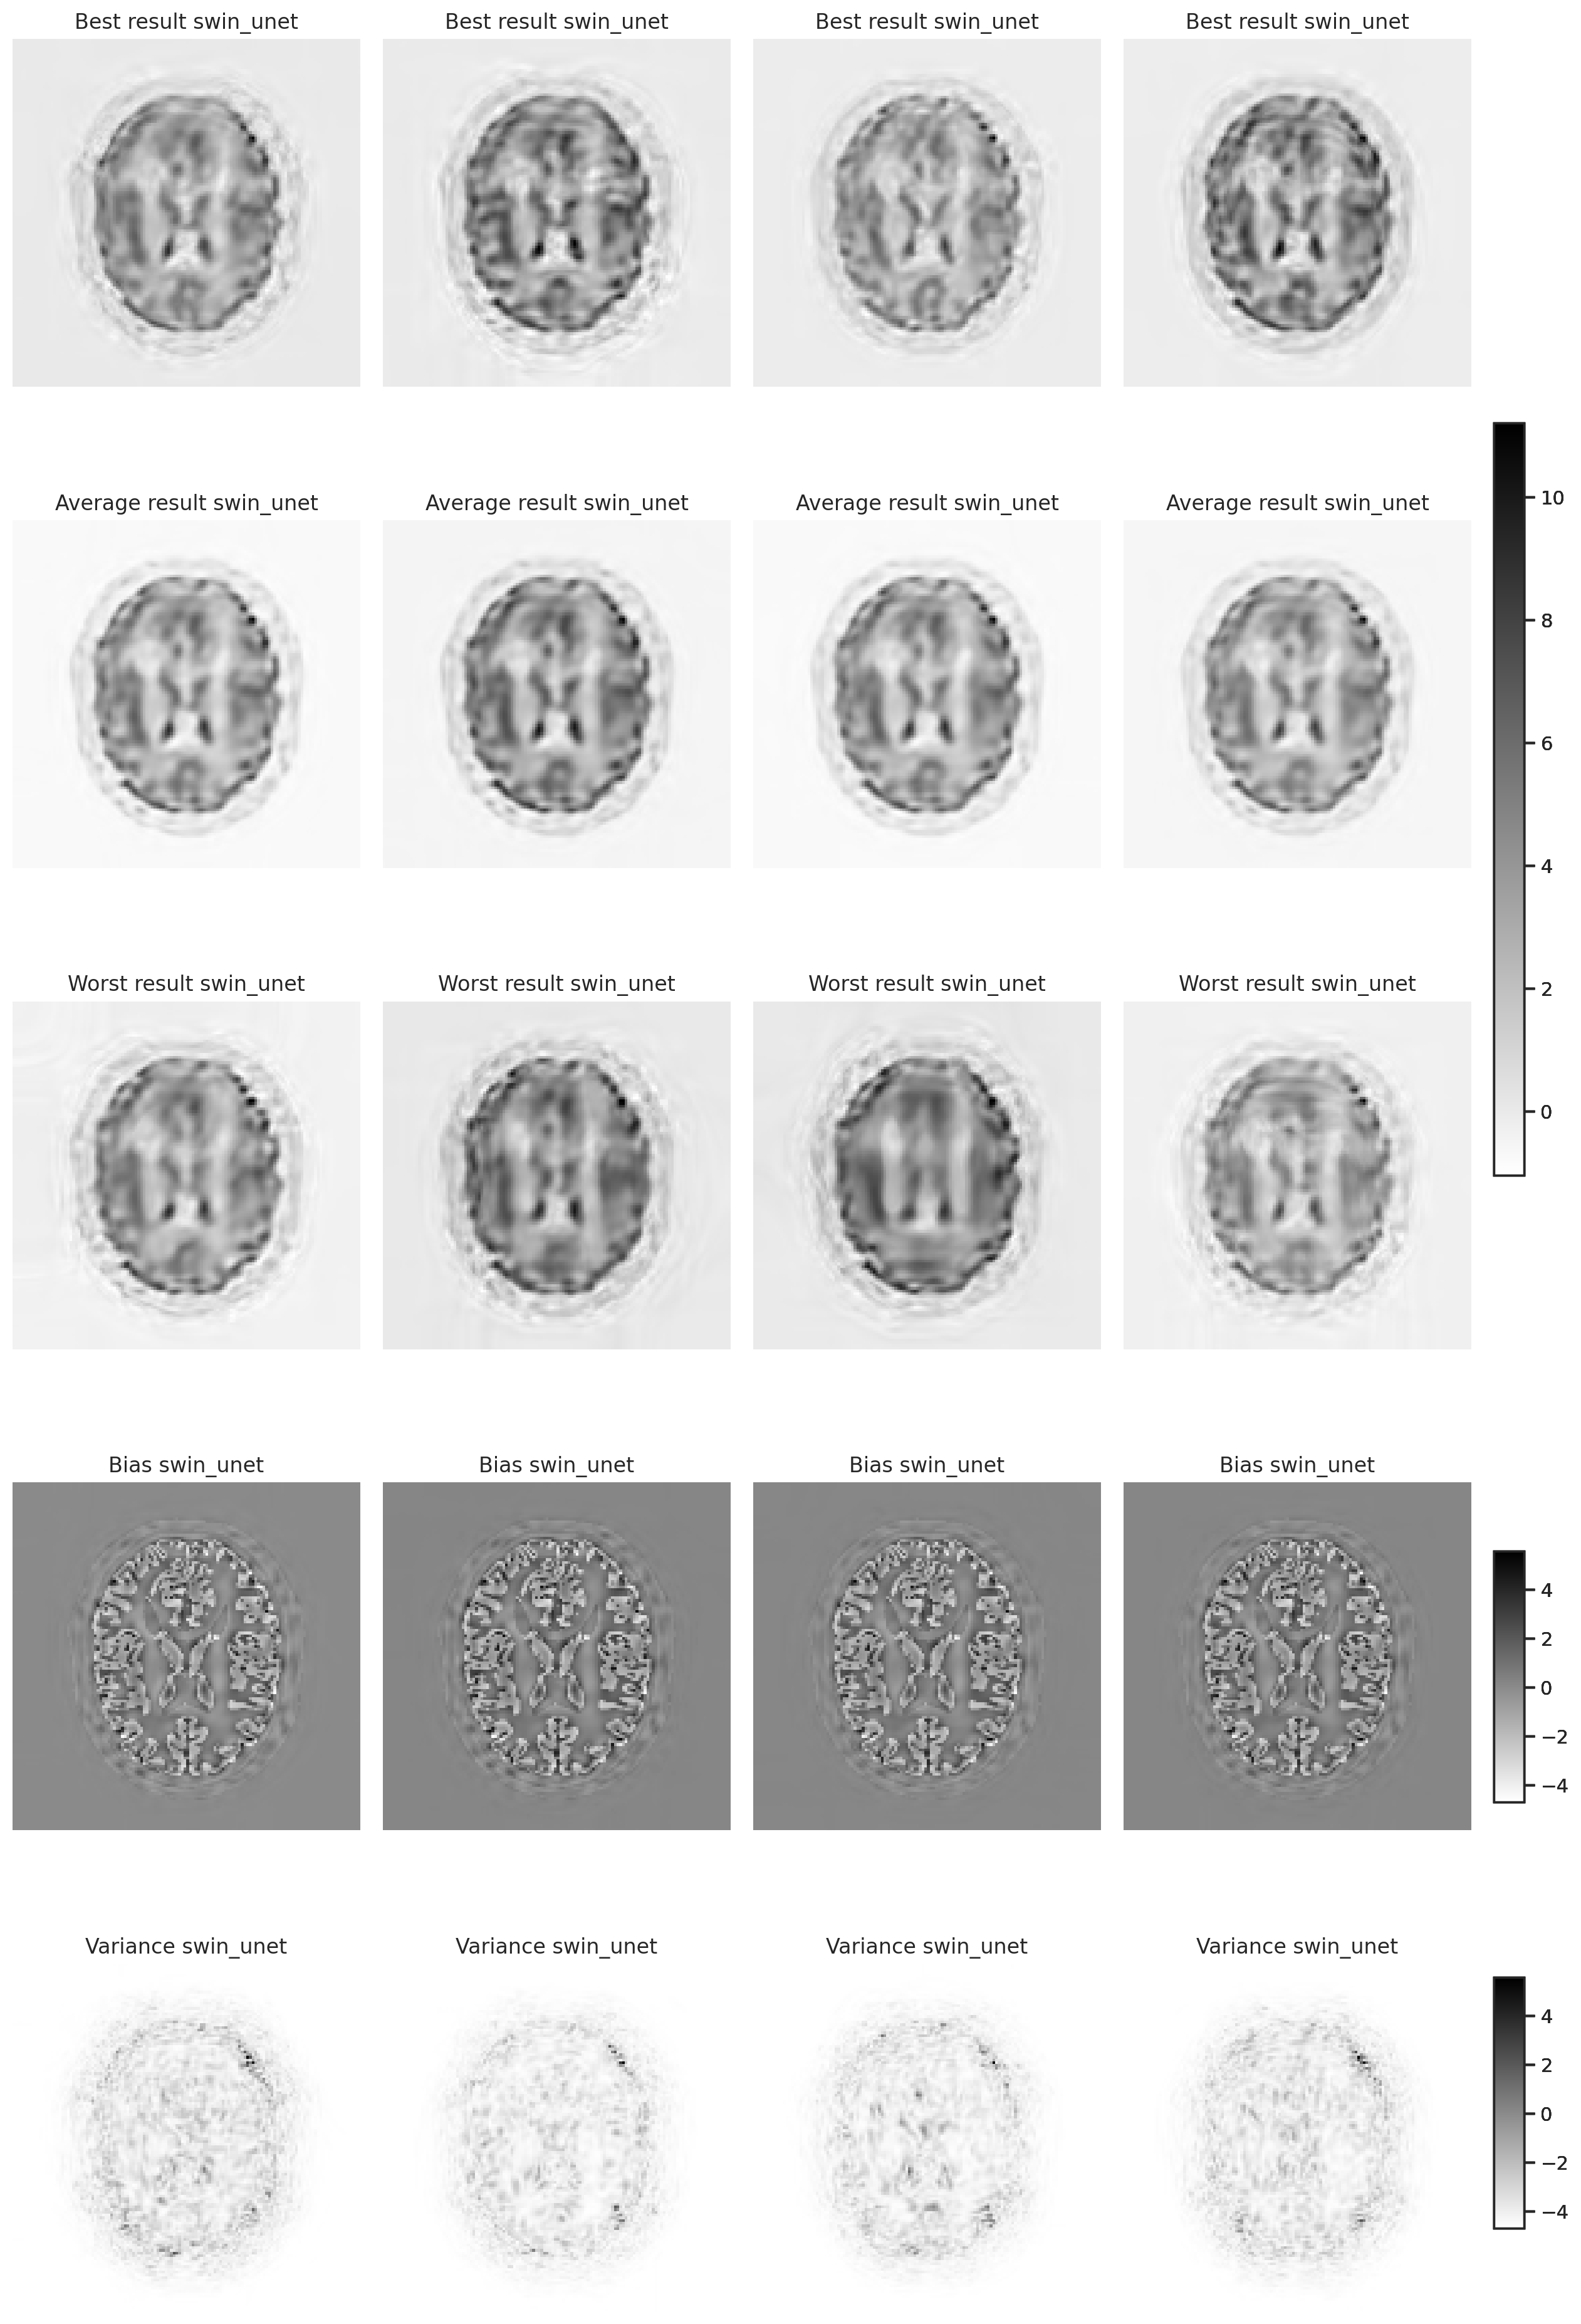

In [118]:
import matplotlib.colors as colors
fig, axs = plt.subplots(5, len(data), figsize=(3* len(data), 20))
fig.subplots_adjust(hspace=0.1)
# 根据上面获得的最佳和最差图片，找到并且打印出来
# 遍历每一行
for i, row in data.iterrows(): 
    # 构造文件路径
    best_image_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/{row['best_result_train']}/iters_{row['b_iteration']}.npy"
    average_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/average.npy"
    worst_image_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/{row['worst_result_train']}/iters_{row['w_iteration']}.npy"
    bias_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/bias.npy"
    variance_path = path_suffix + f"{row['model']}/{row['embed_dims']}_{row['depths']}_{row['num_heads']}_{row['sigma_p']}/variance.npy"
    
    best_image = np.load(best_image_path)
    average_image = np.load(average_path)
    worst_image = np.load(worst_image_path)
    bias_image = np.load(bias_path)
    variance_image = np.load(variance_path)

    axs[0, i].imshow(best_image, cmap='gray_r')
    axs[0, i].set_title(f"Best result {row['model']}")
    axs[0, i].axis('off')
    axs[0, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[1, i].imshow(average_image, cmap='gray_r')
    axs[1, i].set_title(f"Average result {row['model']}")
    axs[1, i].axis('off')
    axs[1, i].set_aspect('equal')  # 设置图像比例为1:1
        
    axs[2, i].imshow(worst_image, cmap='gray_r')
    axs[2, i].set_title(f"Worst result {row['model']}")
    axs[2, i].axis('off')
    axs[2, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[3, i].imshow(bias_image, cmap='gray_r')
    axs[3, i].set_title(f"Bias {row['model']}")
    axs[3, i].axis('off')
    axs[3, i].set_aspect('equal')  # 设置图像比例为1:1
    
    axs[4, i].imshow(variance_image, cmap='gray_r')
    axs[4, i].set_title(f"Variance {row['model']}")
    axs[4, i].axis('off')
    axs[4, i].set_aspect('equal')  # 设置图像比例为1:1
  # 设置colorbar的位置和尺寸
    cax = fig.add_axes([1.0, 0.5, 0.02, 0.3])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[0, 0].images[0], cax=cax)   # 给best_image添加colorbar
    cax = fig.add_axes([1.0, 0.25, 0.02, 0.1])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[3, 0].images[0], cax=cax)
    cax = fig.add_axes([1.0, 0.08, 0.02, 0.1])  # 设置colorbar的位置和尺寸
    fig.colorbar(axs[3, 0].images[0], cax=cax)      
    
# 调整整个图像的布局和尺寸
plt.tight_layout()
plt.show();

In [93]:
data = grouped_df_v3
# data = data[data['model']=='Full_DIP'].reset_index(drop=True)
# data = data.drop(data[data['model']=='gaussian_noise'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='uniform_noise'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='ground_truth_padded'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='gt_add_unform'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v3'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v0'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='Full_DIP_noise_v2'].index).reset_index(drop=True)
# data = data.drop(data[data['sigma_p']=='10'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v1'].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v2'].index).reset_index(drop=True)
# data = data.drop(data[(data['model']=='v0') & (data['sigma_p']=='5') ].index).reset_index(drop=True)
# data = data.drop(data[data['model']=='v3'].index).reset_index(drop=True)
data

,model,embed_dims,depths,num_heads,sigma_p,level_5,best_mse,worst_mse,best_result_train,b_iteration,worst_result_train,w_iteration
0,swin_unetr,48,2,3,0,0,0.497382,0.560645,train_3,103,train_0,96
1,swin_unetr,48,2,6,0,0,0.469111,0.557008,train_3,95,train_5,102
2,swin_unetr,48,4,3,0,0,0.481507,0.595051,train_3,88,train_8,79
3,swin_unetr,48,4,6,0,0,0.501941,0.571073,train_9,127,train_2,98


In [119]:
filtered_data = pd.DataFrame()
df= df_n
data = data
# df['train'] = df['train'].astype('int64')
data['sigma_p'] = data['sigma_p'].astype('int64')
print(df.dtypes)
print(data.dtypes)
# df['sigma_p'] = df['sigma_p'].apply(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))
# 遍历 gdf 中的每一行
for i, row in data.iterrows():
    # 从 df 中提取相应的数据
    condition = (df['model'] == row['model']) & (df['embed_dims'] == row['embed_dims']) & (df['depths'] == row['depths']) & (df['num_heads'] == row['num_heads'])   & (df['train'] == row['best_result_train'])
    extracted_data = df[condition]
    # print(condition)
    # 将提取的数据添加到 filtered_data 中
    filtered_data = filtered_data.append(extracted_data)
filtered_data
print(filtered_data)

model          object
embed_dims      int64
depths          int64
num_heads       int64
sigma_p         int64
train          object
iteration       int64
loss          float64
mse           float64
psnr          float64
ssim          float64
dtype: object
model                  object
embed_dims              int64
depths                  int64
num_heads               int64
sigma_p                 int64
level_5                 int64
best_mse              float64
worst_mse             float64
best_result_train      object
b_iteration             int64
worst_result_train     object
w_iteration             int64
dtype: object


,model,embed_dims,depths,num_heads,sigma_p,train,iteration,loss,mse,psnr,ssim
10200,swin_unet,48,2,3,0,train_7,0,34.790124,34.875263,0.137850,0.000207
10201,swin_unet,48,2,3,0,train_7,1,52.674287,52.746425,-1.658905,0.002015
10202,swin_unet,48,2,3,0,train_7,2,71.121533,71.185629,-2.960898,0.014589
10203,swin_unet,48,2,3,0,train_7,3,11.760138,11.729348,4.870286,0.015352
10204,swin_unet,48,2,3,0,train_7,4,8.367302,8.371930,6.334769,0.007751
...,...,...,...,...,...,...,...,...,...,...,...
17395,swin_unet,48,4,6,0,train_8,595,0.326672,0.632922,17.549525,0.725009
17396,swin_unet,48,4,6,0,train_8,596,0.326695,0.622809,17.619475,0.731504
17397,swin_unet,48,4,6,0,train_8,597,0.326803,0.625939,17.597706,0.725940
17398,swin_unet,48,4,6,0,train_8,598,0.338635,0.633233,17.547392,0.729165


           model  embed_dims  depths  num_heads  sigma_p    train  iteration  \
10200  swin_unet          48       2          3        0  train_7          0   
10201  swin_unet          48       2          3        0  train_7          1   
10202  swin_unet          48       2          3        0  train_7          2   
10203  swin_unet          48       2          3        0  train_7          3   
10204  swin_unet          48       2          3        0  train_7          4   
...          ...         ...     ...        ...      ...      ...        ...   
17395  swin_unet          48       4          6        0  train_8        595   
17396  swin_unet          48       4          6        0  train_8        596   
17397  swin_unet          48       4          6        0  train_8        597   
17398  swin_unet          48       4          6        0  train_8        598   
17399  swin_unet          48       4          6        0  train_8        599   

            loss        mse       psnr 

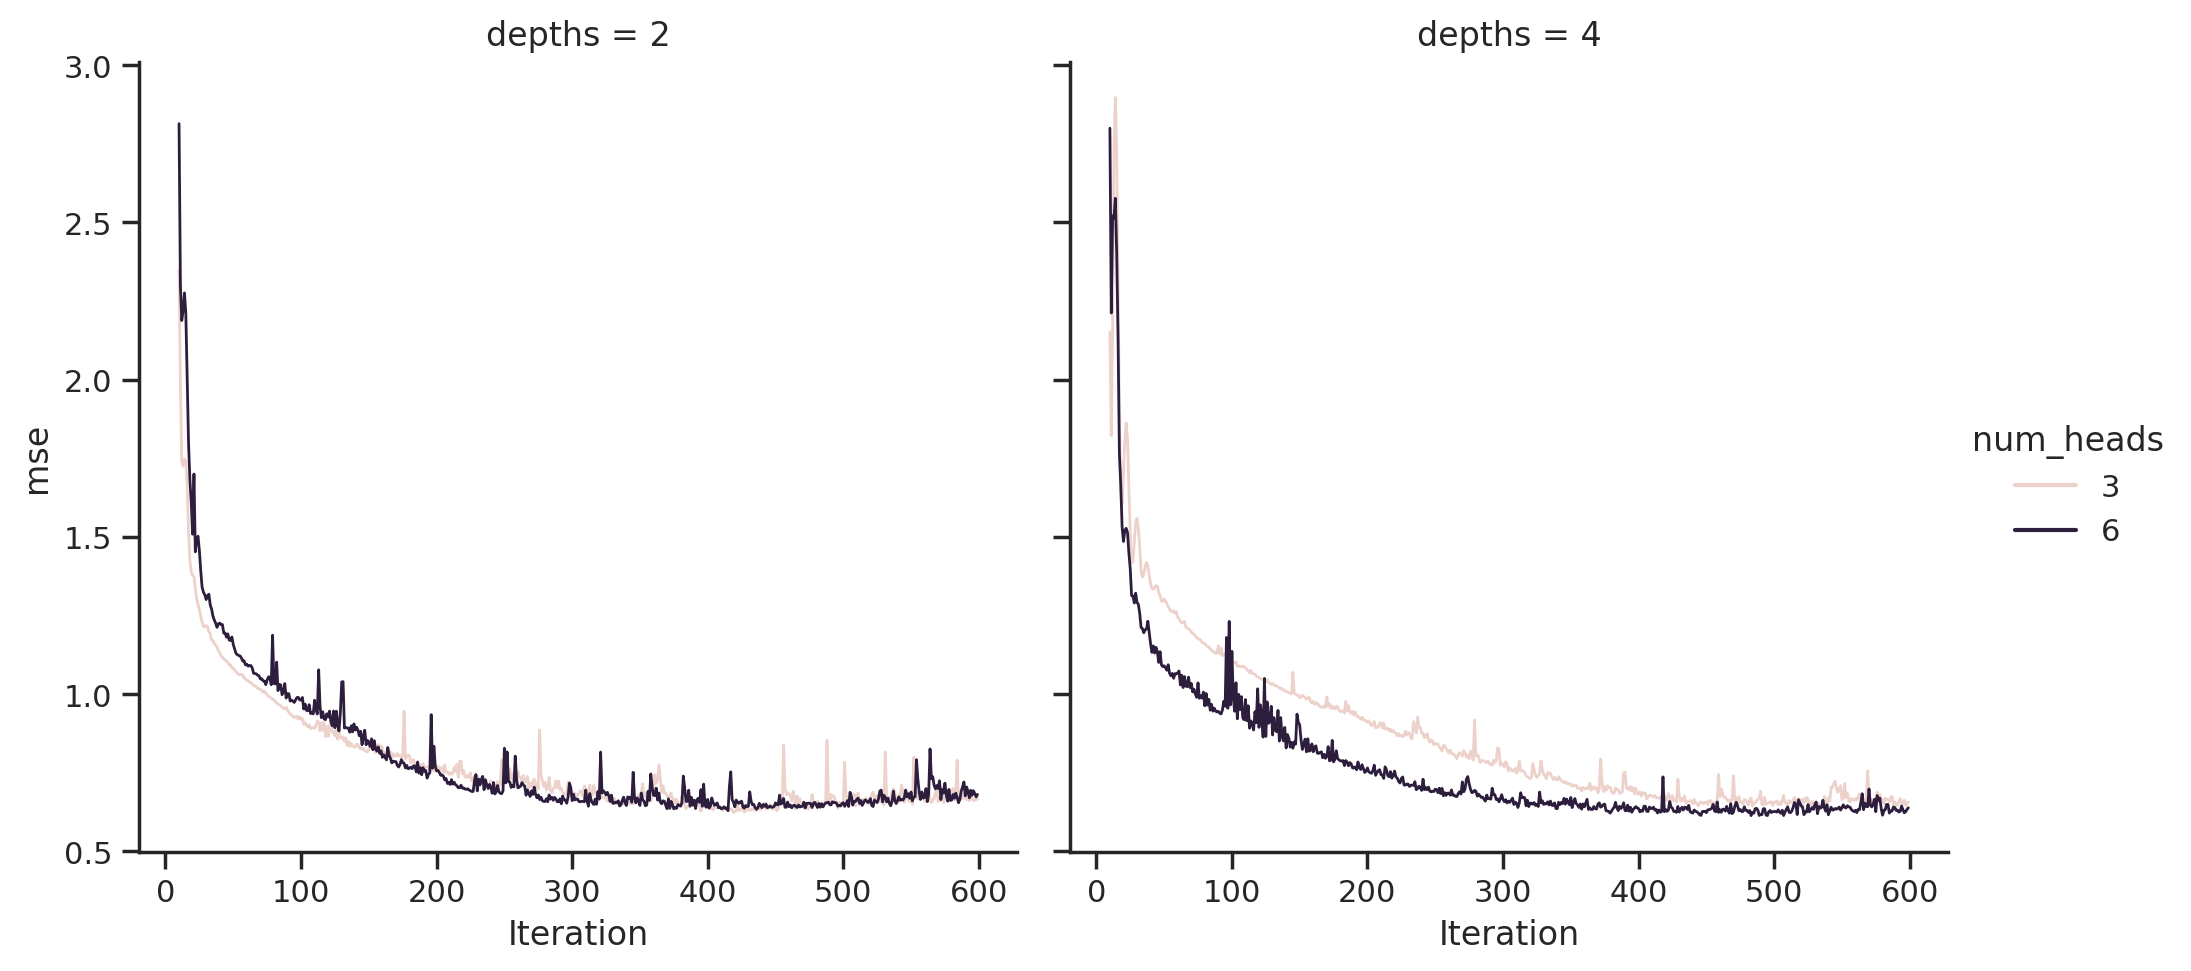

In [120]:
filtered_data = filtered_data [(filtered_data ["iteration"] >=10) & (filtered_data ["iteration"] <= 1000)]
g = sns.relplot(
    data=filtered_data,
    hue='num_heads',
    x='iteration',
    y='mse',
    kind='line',
    col='depths',
    # style='sigma_p',
    dashes=False,
    ci=None,
    linewidth=1
)

# 设置坐标轴标签和标题
g.set(xlabel="Iteration", ylabel='mse')

# 显示图形
plt.show();
